In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver

from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
from Problem.LogDataHandling import *

In [3]:
optimal_parameters = {"SA":{"mutation":0.9}, "GA":{"mutation":0.9,"crossover":0.25,"population_size":30},
                     "NSGAII":{"mutation":0.9,"crossover":0.50,"population_size":30},
                     "NSGAIII":{"mutation":0.9,"crossover":0.50,"population_size":20},
                     "UNSGAIII":{"mutation":0.9,"crossover":0.25,"population_size":20},
                     "IBEA":{"mutation":0.9,"crossover":0.75,"population_size":20}}

In [4]:
imgs_path = "../src/imgs"

# Helper functions

In [120]:
def _mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), sp.stats.sem(a)
    h = se * sp.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def find_fithess_within_percentage_df(dataframe,percentage):
    time_points=[]
    for index,row in dataframe.iterrows():
        final_val = row.fuel_consumption_final
        worst_value_index = np.argsort(row.fuel_consumption)[-1] 

        percentage_range_value = final_val * (1 + percentage)
        if (worst_value := np.array(row.fuel_consumption)[worst_value_index])  < percentage_range_value:
                percentage_range_value = worst_value 

        if final_val == worst_value:
            time_points.append(np.array(row.computation_times)[0])
            continue

        within_range = np.argwhere(np.diff(np.sign(percentage_range_value - np.array(row.fuel_consumption)))).flatten()
        result = list(filter(lambda x: x >= worst_value_index,within_range))[0]
        time_points.append(np.array(row.computation_times)[result])
    return time_points


def add_final_compute_time_column(dataframe):
    if not "computation_times_final" in dataframe.columns:
        if type(dataframe.computation_times.iloc[0]) == str:
            dataframe.computation_times = dataframe.computation_times.apply(literal_eval)
        
        
        dataframe["computation_times_final"] = find_fithess_within_percentage_df(dataframe,0.05)#[dataframe.computation_times.loc[i][-1] for i in list(dataframe.index)]


def combine_datasets(algorithm_name, log_data_path, datasets=["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]):
    simulations = []
    if type(datasets) == list:
        for dataset_name in datasets:
            try:
                simulation = pd.read_csv("%s%s/%s.csv" % (log_data_path, dataset_name, algorithm_name))
            except:
                print("Error, file not found: %s%s/%s.csv" % (log_data_path, dataset_name, algorithm_name))
            if dataset_name == "UK25_2":
                try:
                    simulation = remove_unwanted_mutation_parameter_groups(simulation)
                    if algorithm_name == "SA":
                        simulation["Parameter Group"] = simulation["Parameter Group"]/2
                    else:
                        simulation["Parameter Group"] = sorted(list(range(45)) * 30)
                except:
                    #print("No parameter groups to alter.")
                    pass
            simulation["dataset"] = dataset_name
            simulations.append(simulation)
    else:
            try:
                simulation = pd.read_csv("%s%s/%s.csv" % (log_data_path, datasets, algorithm_name))
            except:
                print("Error, file not found: %s%s/%s.csv" % (log_data_path, datasets, algorithm_name))
            if datasets == "UK25_2":
                try:
                    simulation = remove_unwanted_mutation_parameter_groups(simulation)
                    if algorithm_name == "SA":
                        simulation["Parameter Group"] = simulation["Parameter Group"]/2
                    else:
                        simulation["Parameter Group"] = sorted(list(range(45)) * 30)
                except:
                    #print("No parameter groups to alter.")
                    pass
            simulation["dataset"] = datasets
            simulations.append(simulation)
        
    
    for df in simulations:
        add_final_fitness_columns(df)
        try:
            expand_parameter_colums(df)
        except:
            #print("No parameter columns to expand")
            pass
        add_distance_to_origin(df)
        add_final_compute_time_column(df)
        
        df["num_evaluations"] = len(df.fitness.apply(literal_eval).apply(np.array)[0])*60
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.fuel_consumption_final)
        df["fuel_consumption_final_mean"] = mean_f0
        df["fuel_consumption_final_min"] = min_f0
        df["fuel_consumption_final_max"] = max_f0
        
        max_fuel_consumption = max(df.fuel_consumption_final)
        min_fuel_consumption = min(df.fuel_consumption_final)
        df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption - min_fuel_consumption)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.fuel_consumption_final_minmax)
        df["fuel_consumption_final_minmax_mean"] = mean_f0
        df["fuel_consumption_final_minmax_min"] = min_f0
        df["fuel_consumption_final_minmax_max"] = max_f0
        
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.longest_route_time_final)
        df["longest_route_time_final_mean"] = mean_f0
        df["longest_route_time_final_min"] = min_f0
        df["longest_route_time_final_max"] = max_f0
        
        max_longest_route_time_final = max(df.longest_route_time_final)
        min_longest_route_time_final = min(df.longest_route_time_final)
        df["longest_route_time_final_minmax"] = (df.longest_route_time_final - min_longest_route_time_final)/(max_longest_route_time_final - min_longest_route_time_final)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.longest_route_time_final_minmax)
        df["longest_route_time_final_minmax_mean"] = mean_f0
        df["longest_route_time_final_minmax_min"] = min_f0
        df["longest_route_time_final_minmax_max"] = max_f0
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.computation_times_final)
        df["computation_times_final_mean"] = mean_f0
        df["computation_times_final_min"] = min_f0
        df["computation_times_final_max"] = max_f0
        
        max_computation_times_final = max(df.computation_times_final)
        min_computation_times_final = min(df.computation_times_final)
        df["computation_times_final_minmax"] = (df.computation_times_final - min_computation_times_final)/(max_computation_times_final - min_computation_times_final)

        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.distance_to_origin)
        df["distance_to_origin_mean"] = mean_f0
        df["distance_to_origin_min"] = min_f0
        df["distance_to_origin_max"] = max_f0
        
        max_distance_to_origin = max(df.distance_to_origin)
        min_distance_to_origin = min(df.distance_to_origin)
        df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin - min_distance_to_origin)
        
    return pd.concat(simulations)



def plot_2d_minmax_scaled(datapoints, labels, show_mean_eval=False, minmax_scale = True,marker_kwargs={"SA":{"color":"#1f77b4", "marker":"o"}, "NSGA-II": {"color":"#ff7f0e", "marker":"P"}, "NSGA-III":{"color":"#2ca02c", "marker":"s"}, "IBEA":{"color":"#d62728", "marker":"D"}, "IBEA-Adaptive":{"color":"#9467bd", "marker":">"}, "UNSGA-III":{"color":"#8c564b", "marker":"X"}, "GA":{"color":"#e377c2", "marker":"p"}}):
    
    marker_kwargs["SA-P&D"] = {"color":"#8c564b", "marker":"o"}
    marker_kwargs["IBEA-P&D"] = {"color":"#ff7f0e", "marker":"D"}
    marker_kwargs["NSGA-III-P&D"] = {"color":"#e377c2", "marker":"s"}
    
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig,ax = plt.subplots(1,1)
    for data, label in zip(datapoints, labels):

        if minmax_scale:
            mean_f0,min_f0,max_f0 =  data.fuel_consumption_final_minmax_mean, data.fuel_consumption_final_minmax_min, data.fuel_consumption_final_minmax_max
            mean_f1,min_f1,max_f1 =  data.longest_route_time_final_minmax_mean, data.longest_route_time_final_minmax_min, data.longest_route_time_final_minmax_max
        else:
            mean_f0,min_f0,max_f0 =  data.fuel_consumption_final_mean, data.fuel_consumption_final_min, data.fuel_consumption_final_max
            mean_f1,min_f1,max_f1 =  data.longest_route_time_final_mean, data.longest_route_time_final_min, data.longest_route_time_final_max
        if "P&D" in label:
            ax.plot([min_f0,max_f0],[mean_f1,mean_f1],zorder=1, c="k", linestyle="dotted")
            ax.plot([mean_f0,mean_f0],[min_f1,max_f1],zorder=1, c="k", linestyle="dotted")
        else:
            ax.plot([min_f0,max_f0],[mean_f1,mean_f1],zorder=1, c="k", linestyle="--")
            ax.plot([mean_f0,mean_f0],[min_f1,max_f1],zorder=1, c="k", linestyle="--")
        if show_mean_eval:
            plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {} \nMean Evaluations: {}".format(
                                                                                     round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                                     round(min_f1,2),round(mean_f1,2),round(max_f1,2), round(data.num_evaluations))
        else:
            plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}".format(
                                                                         round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                         round(min_f1,2),round(mean_f1,2),round(max_f1,2))

        ax.scatter(x= mean_f0, y=mean_f1, label=plotlabel, s=250, **marker_kwargs[label], zorder=2)
    return fig, ax
def plot_vehicle_drivetimes(dataframe,dataset):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)
    
    dataframe_parameter_group = dataframe.where(dataframe.dataset == dataset).dropna()
    
    if type(dataframe_parameter_group.vehicle_route_time.iloc[0]) == str:
        dataframe_parameter_group.vehicle_route_time = dataframe_parameter_group.vehicle_route_time.apply(literal_eval)
        
    dataframe_parameter_group["vehicle_amount"] = dataframe_parameter_group.vehicle_route_time.apply(lambda x: len(x))
    
    vehicle_amounts = sorted(dataframe_parameter_group.vehicle_amount.unique())
    num_bars = len(vehicle_amounts)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)
    
    for vehicle_amount,offset in zip(vehicle_amounts,offsets):
        vehicle_amount_df = dataframe_parameter_group.where(dataframe_parameter_group.vehicle_amount == vehicle_amount).dropna()
        
        vehicle_amount_route_times = np.stack(vehicle_amount_df.vehicle_route_time.apply(lambda x: np.sort(x)[::-1]/60).to_numpy())
        vehicle_route_times_mean = np.mean(vehicle_amount_route_times,axis=0)
        mean_route_time_sum = int(np.round(sum(vehicle_route_times_mean),0))
        plt.bar(np.arange(vehicle_amount) + offset,vehicle_route_times_mean,width=0.2,alpha=0.5,label=r"$\bf{%s}\ Vehicles:\ %s min$" % (vehicle_amount, mean_route_time_sum))
    
    plt.ylabel("Drivetime (minutes)")
    plt.xlabel("Vehicle nr")
    plt.legend(bbox_to_anchor=(1,1))
        
    
    

In [36]:
def add_minmax_fuel_drivetime_columns(dataframes):
    max_fuel_consumptions = {}
    min_fuel_consumptions = {}
    max_drivetimes = {}
    min_drivetimes = {}
    
    datasets = dataframes[0].dataset.unique()
    for dataset in datasets:
        if not dataset in max_fuel_consumptions.keys():
            max_fuel_consumptions[dataset] = 0
            min_fuel_consumptions[dataset]  = 10e10
            max_drivetimes[dataset]  = 0
            min_drivetimes[dataset]  = 10e10
        for dataframe in dataframes:

            dataframe_max_fuel = dataframe.where(dataframe.dataset == dataset).dropna().fuel_consumption_final.max()
            dataframe_min_fuel = dataframe.where(dataframe.dataset == dataset).dropna().fuel_consumption_final.min()

            dataframe_max_drivetime = dataframe.where(dataframe.dataset == dataset).dropna().longest_route_time_final.max()
            dataframe_min_drivetime = dataframe.where(dataframe.dataset == dataset).dropna().longest_route_time_final.min()

            if dataframe_max_fuel > max_fuel_consumptions[dataset]:
                max_fuel_consumptions[dataset] = dataframe_max_fuel

            if dataframe_min_fuel < min_fuel_consumptions[dataset]:
                min_fuel_consumptions[dataset] = dataframe_min_fuel

            if dataframe_max_drivetime > max_drivetimes[dataset]:
                max_drivetimes[dataset] = dataframe_max_drivetime

            if dataframe_min_drivetime < min_drivetimes[dataset]:
                min_drivetimes[dataset] = dataframe_min_drivetime
                
    for dataset in datasets:
        for dataframe in dataframes:
        
            max_fuel_consumption = max_fuel_consumptions[dataset]
            min_fuel_consumption = min_fuel_consumptions[dataset]
            
            max_longest_route_time_final = max_drivetimes[dataset]
            min_longest_route_time_final = min_drivetimes[dataset]
            
            dataframe_fuel_consumption_scaled = (dataframe.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption - min_fuel_consumption)

            dataframe['fuel_consumption_final_minmax'] = np.where((dataframe.dataset == dataset),dataframe_fuel_consumption_scaled,dataframe.fuel_consumption_final_minmax)
            
            dataframe_longest_drivetime_scaled = (dataframe.longest_route_time_final - min_longest_route_time_final)/(max_longest_route_time_final - min_longest_route_time_final)
            dataframe['longest_route_time_final_minmax'] = np.where((dataframe.dataset == dataset),dataframe_longest_drivetime_scaled,dataframe.longest_route_time_final_minmax)
      
            mean_f0, min_f0, max_f0 = _mean_confidence_interval(dataframe.fuel_consumption_final_minmax)
            dataframe["fuel_consumption_final_minmax_mean"] = mean_f0
            dataframe["fuel_consumption_final_minmax_min"] = min_f0
            dataframe["fuel_consumption_final_minmax_max"] = max_f0

            mean_f0, min_f0, max_f0 = _mean_confidence_interval(dataframe.longest_route_time_final_minmax)
            dataframe["longest_route_time_final_minmax_mean"] = mean_f0
            dataframe["longest_route_time_final_minmax_min"] = min_f0
            dataframe["longest_route_time_final_minmax_max"] = max_f0


In [43]:
def add_minmax_fuel_drivetime_columns(dataframes,datasets = None):
    max_fuel_consumptions = {}
    min_fuel_consumptions = {}
    max_drivetimes = {}
    min_drivetimes = {}
    if datasets == None:
        datasets = dataframes[0].dataset.unique()
        
    for dataset in datasets:
        if not dataset in max_fuel_consumptions.keys():
            max_fuel_consumptions[dataset] = 0
            min_fuel_consumptions[dataset]  = 10e10
            max_drivetimes[dataset]  = 0
            min_drivetimes[dataset]  = 10e10
        for dataframe in dataframes:

            dataframe_max_fuel = dataframe.where(dataframe.dataset == dataset).dropna().fuel_consumption_final.max()
            dataframe_min_fuel = dataframe.where(dataframe.dataset == dataset).dropna().fuel_consumption_final.min()

            dataframe_max_drivetime = dataframe.where(dataframe.dataset == dataset).dropna().longest_route_time_final.max()
            dataframe_min_drivetime = dataframe.where(dataframe.dataset == dataset).dropna().longest_route_time_final.min()

            if dataframe_max_fuel > max_fuel_consumptions[dataset]:
                max_fuel_consumptions[dataset] = dataframe_max_fuel

            if dataframe_min_fuel < min_fuel_consumptions[dataset]:
                min_fuel_consumptions[dataset] = dataframe_min_fuel

            if dataframe_max_drivetime > max_drivetimes[dataset]:
                max_drivetimes[dataset] = dataframe_max_drivetime

            if dataframe_min_drivetime < min_drivetimes[dataset]:
                min_drivetimes[dataset] = dataframe_min_drivetime
    for dataframe in dataframes:
        fuel_minmax = []  
        longest_minmax = []
        
        for dataset in datasets:
       
        
            max_fuel_consumption = max_fuel_consumptions[dataset]
            min_fuel_consumption = min_fuel_consumptions[dataset]
            
            max_longest_route_time_final = max_drivetimes[dataset]
            min_longest_route_time_final = min_drivetimes[dataset]
            
            dataframe_fuel_consumption_scaled = np.array((dataframe.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption - min_fuel_consumption))
            fuel_minmax.extend(dataframe_fuel_consumption_scaled[np.where(dataframe.dataset == dataset)])
            
            dataframe_longest_drivetime_scaled = np.array((dataframe.longest_route_time_final - min_longest_route_time_final)/(max_longest_route_time_final - min_longest_route_time_final))
            longest_minmax.extend(dataframe_longest_drivetime_scaled[np.where(dataframe.dataset == dataset)])

      
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(fuel_minmax)
        dataframe["fuel_consumption_final_minmax_mean"] = mean_f0
        dataframe["fuel_consumption_final_minmax_min"] = min_f0
        dataframe["fuel_consumption_final_minmax_max"] = max_f0

        mean_f0, min_f0, max_f0 = _mean_confidence_interval(longest_minmax)
        dataframe["longest_route_time_final_minmax_mean"] = mean_f0
        dataframe["longest_route_time_final_minmax_min"] = min_f0
        dataframe["longest_route_time_final_minmax_max"] = max_f0




In [10]:
import time 
start_time = time.monotonic()

print("SA")
SA_data_time_limited = combine_datasets("SA", "time_limited_test_data/")
print("GA")
GA_data_time_limited = combine_datasets("GA", "time_limited_test_data/")
print("NSGA2")
NSGA2_data_time_limited = combine_datasets("NSGA2", "time_limited_test_data/")
print("NSGA3")
NSGA3_data_time_limited = combine_datasets("NSGA3", "time_limited_test_data/")
print("UNSGA3")
UNSGA3_data_time_limited = combine_datasets("UNSGA3", "time_limited_test_data/")
print("IBEA")
IBEA_data_time_limited = combine_datasets("IBEA", "time_limited_test_data/")

add_minmax_fuel_drivetime_columns([SA_data_time_limited,GA_data_time_limited,
                                   NSGA2_data_time_limited,NSGA3_data_time_limited,
                                   UNSGA3_data_time_limited,IBEA_data_time_limited])

SA_data_time_limited_mean = SA_data_time_limited.mean()
GA_data_time_limited_mean = GA_data_time_limited.mean()
NSGA2_data_time_limited_mean = NSGA2_data_time_limited.mean()
NSGA3_data_time_limited_mean = NSGA3_data_time_limited.mean()
UNSGA3_data_time_limited_mean = UNSGA3_data_time_limited.mean()
IBEA_data_time_limited_mean = IBEA_data_time_limited.mean()


print("Time: ", time.monotonic() - start_time)

SA
GA
NSGA2
NSGA3
UNSGA3
IBEA
Time:  2.9901066729999


In [44]:
import time 
start_time = time.monotonic()
print("SA")
SA_data_evaluation_limited = combine_datasets("SA", "parameter_data/reruns/")
#SA_data_evaluation_limited = SA_data_evaluation_limited.where(SA_data_evaluation_limited["Parameter Group"] == 4).dropna()
print("GA")
GA_data_evaluation_limited = combine_datasets("GA", "parameter_data/reruns/")
#GA_data_evaluation_limited = GA_data_evaluation_limited.where(GA_data_evaluation_limited["Parameter Group"] == 38).dropna()
print("NSGA2")
NSGA2_data_evaluation_limited = combine_datasets("NSGA2", "parameter_data/reruns_L1/")
print("NSGA3")
NSGA3_data_evaluation_limited = combine_datasets("NSGA3", "parameter_data/reruns_L1/")
print("UNSGA3")
UNSGA3_data_evaluation_limited = combine_datasets("UNSGA3", "parameter_data/reruns_L1/")
print("IBEA")
IBEA_data_evaluation_limited = combine_datasets("IBEA", "parameter_data/reruns_L1/")
add_minmax_fuel_drivetime_columns([SA_data_evaluation_limited,GA_data_evaluation_limited,
                                   NSGA2_data_evaluation_limited,NSGA3_data_evaluation_limited,
                                   UNSGA3_data_evaluation_limited,IBEA_data_evaluation_limited])
SA_data_evaluation_limited_mean = SA_data_evaluation_limited.mean()
GA_data_evaluation_limited_mean = GA_data_evaluation_limited.mean()
NSGA2_data_evaluation_limited_mean = NSGA2_data_evaluation_limited.mean()
NSGA3_data_evaluation_limited_mean = NSGA3_data_evaluation_limited.mean()
UNSGA3_data_evaluation_limited_mean = UNSGA3_data_evaluation_limited.mean()
IBEA_data_evaluation_limited_mean = IBEA_data_evaluation_limited.mean()
print("Time: ", time.monotonic() - start_time)

SA
GA
NSGA2
NSGA3
UNSGA3
IBEA
Time:  3.75932395899963


# Plot Time limited to 5s

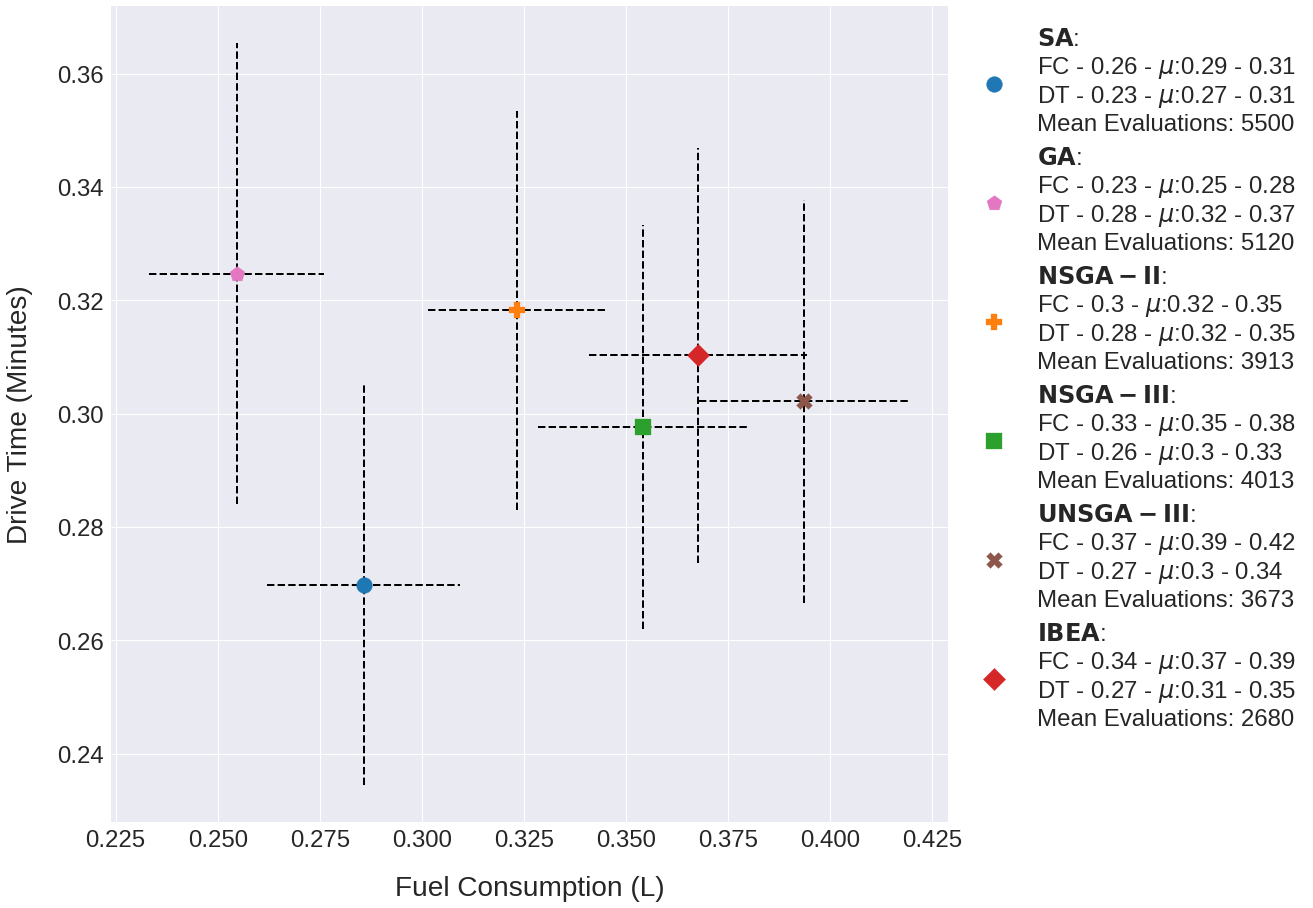

In [75]:
algorithms = [SA_data_time_limited_mean, GA_data_time_limited_mean, NSGA2_data_time_limited_mean, NSGA3_data_time_limited_mean, UNSGA3_data_time_limited_mean, IBEA_data_time_limited_mean]
labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
fig, ax = plot_2d_minmax_scaled(algorithms, labels, show_mean_eval=True)
plt.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
#plt.tight_layout(pad=2)
plt.show()

In [46]:
fig.savefig("{}/confidence_plot_2d_5s_time_limited.pdf".format(imgs_path), bbox_inches='tight')

# Plot Time limited to 5s for all datasets

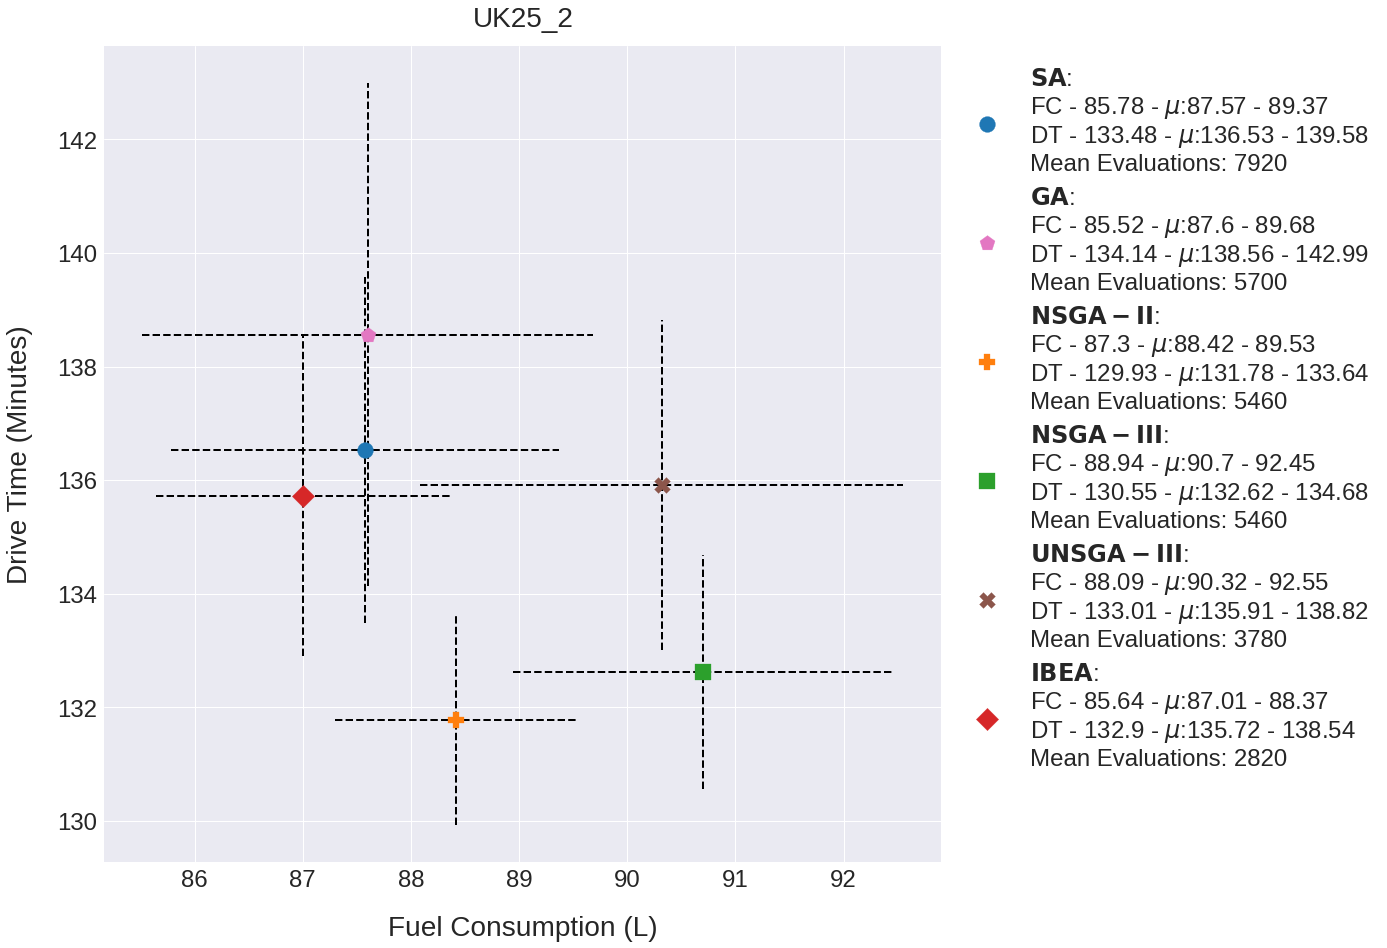

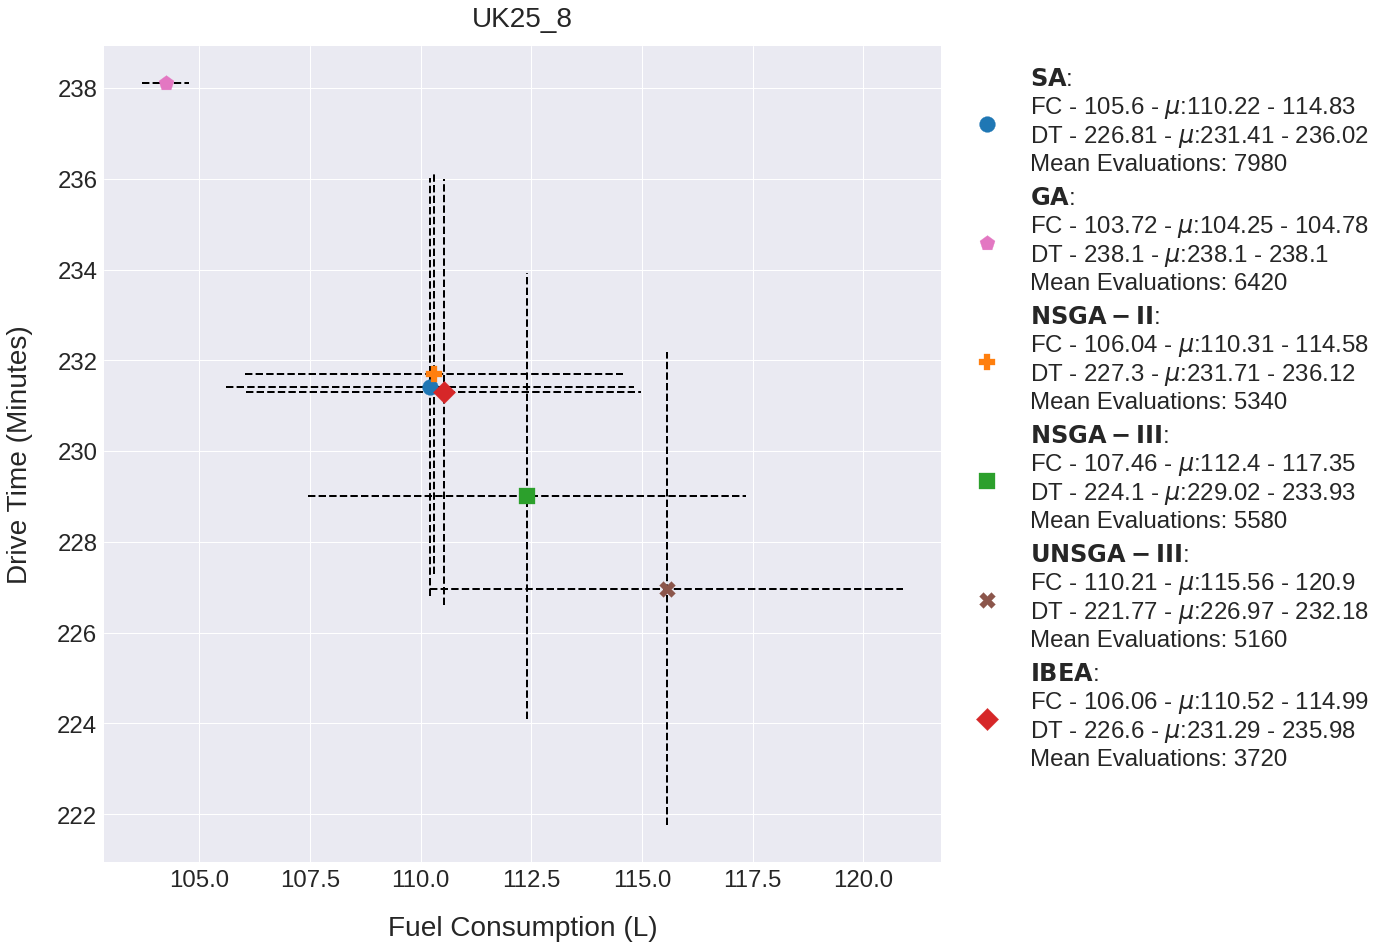

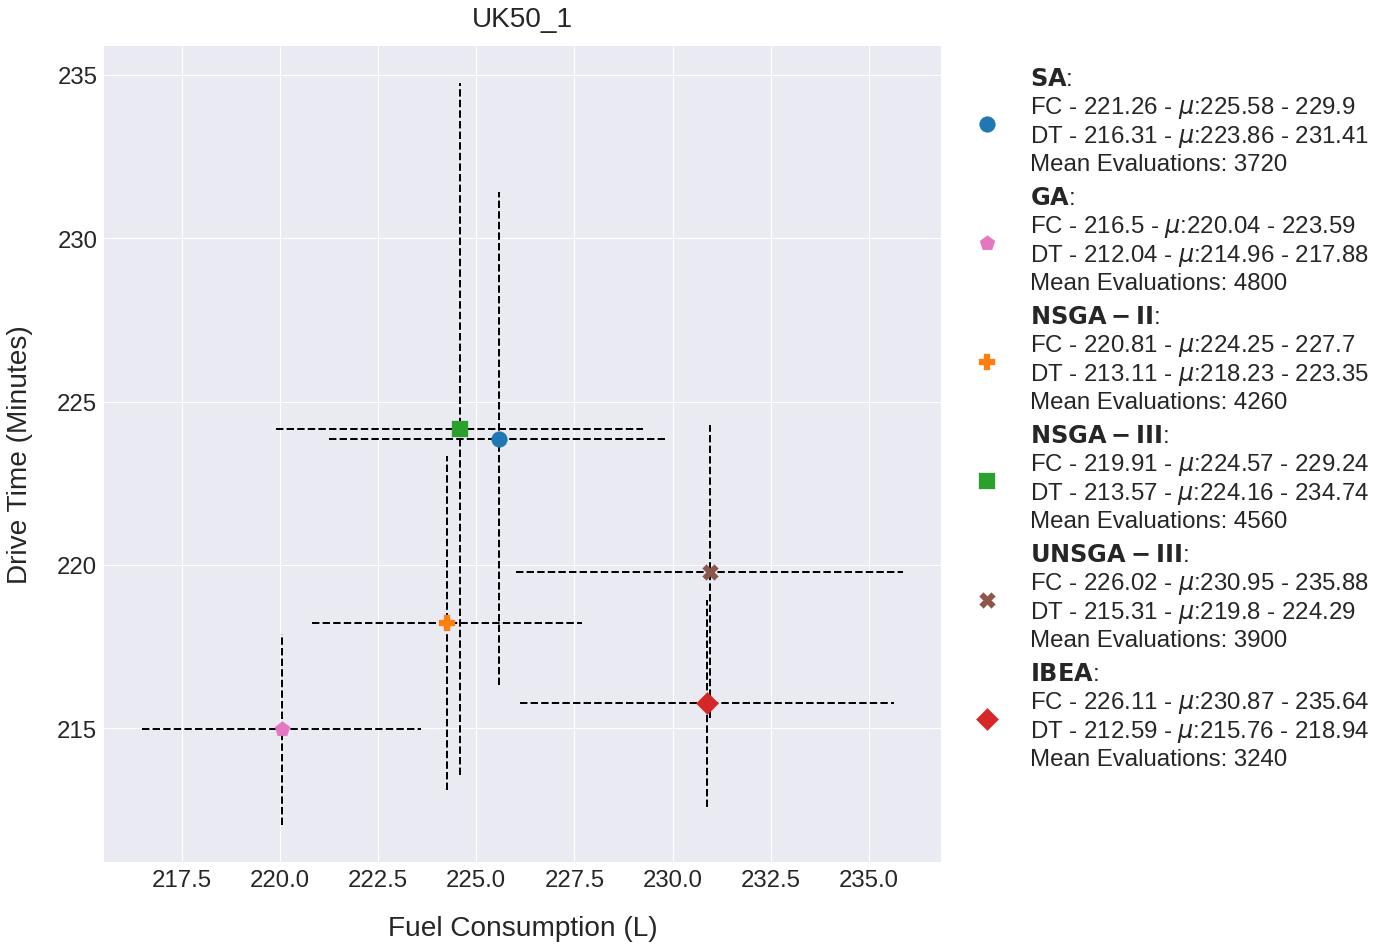

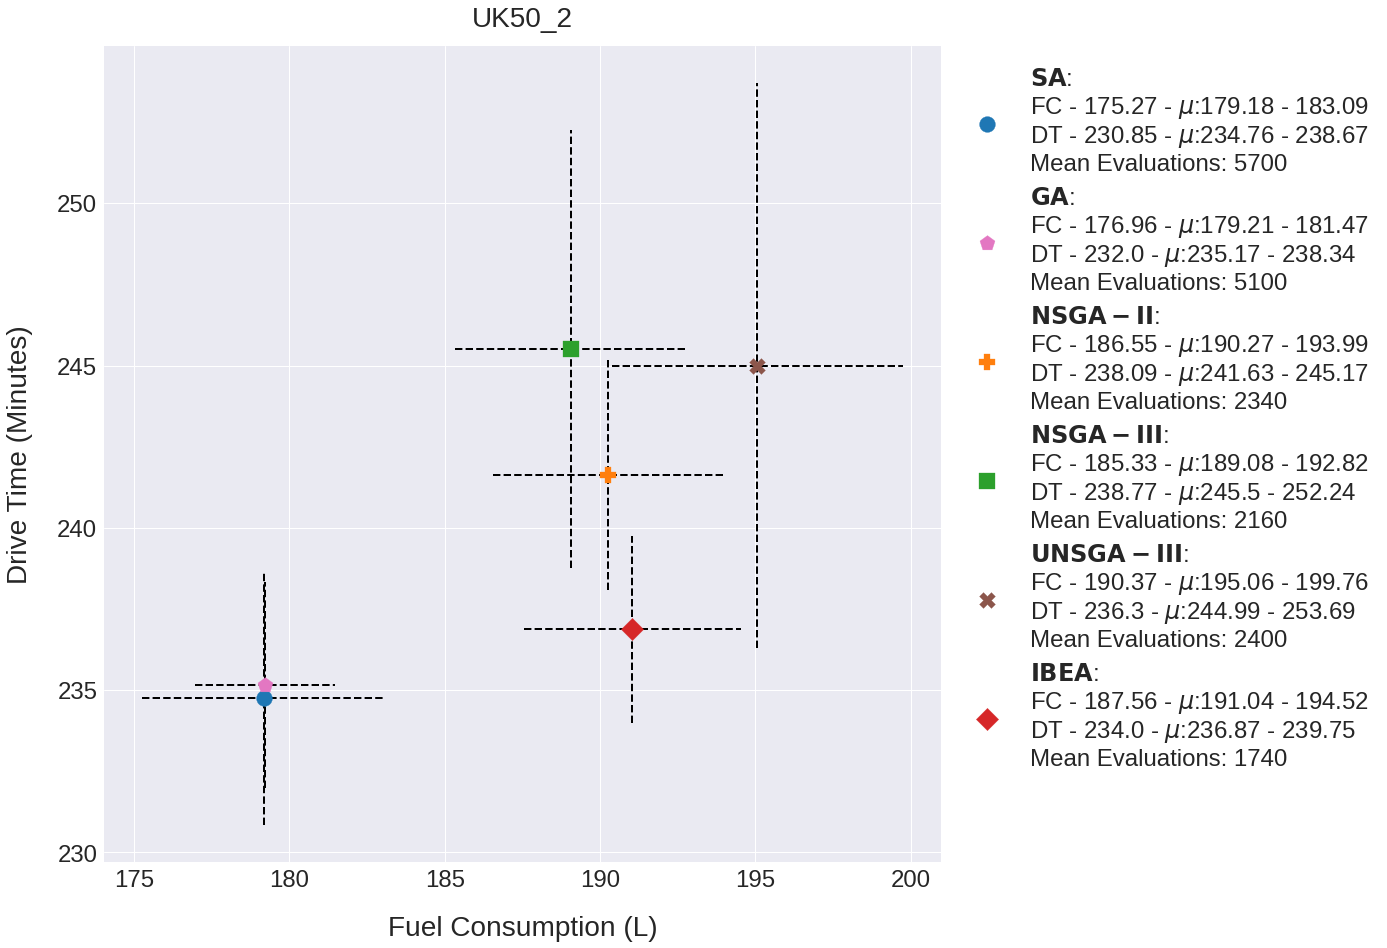

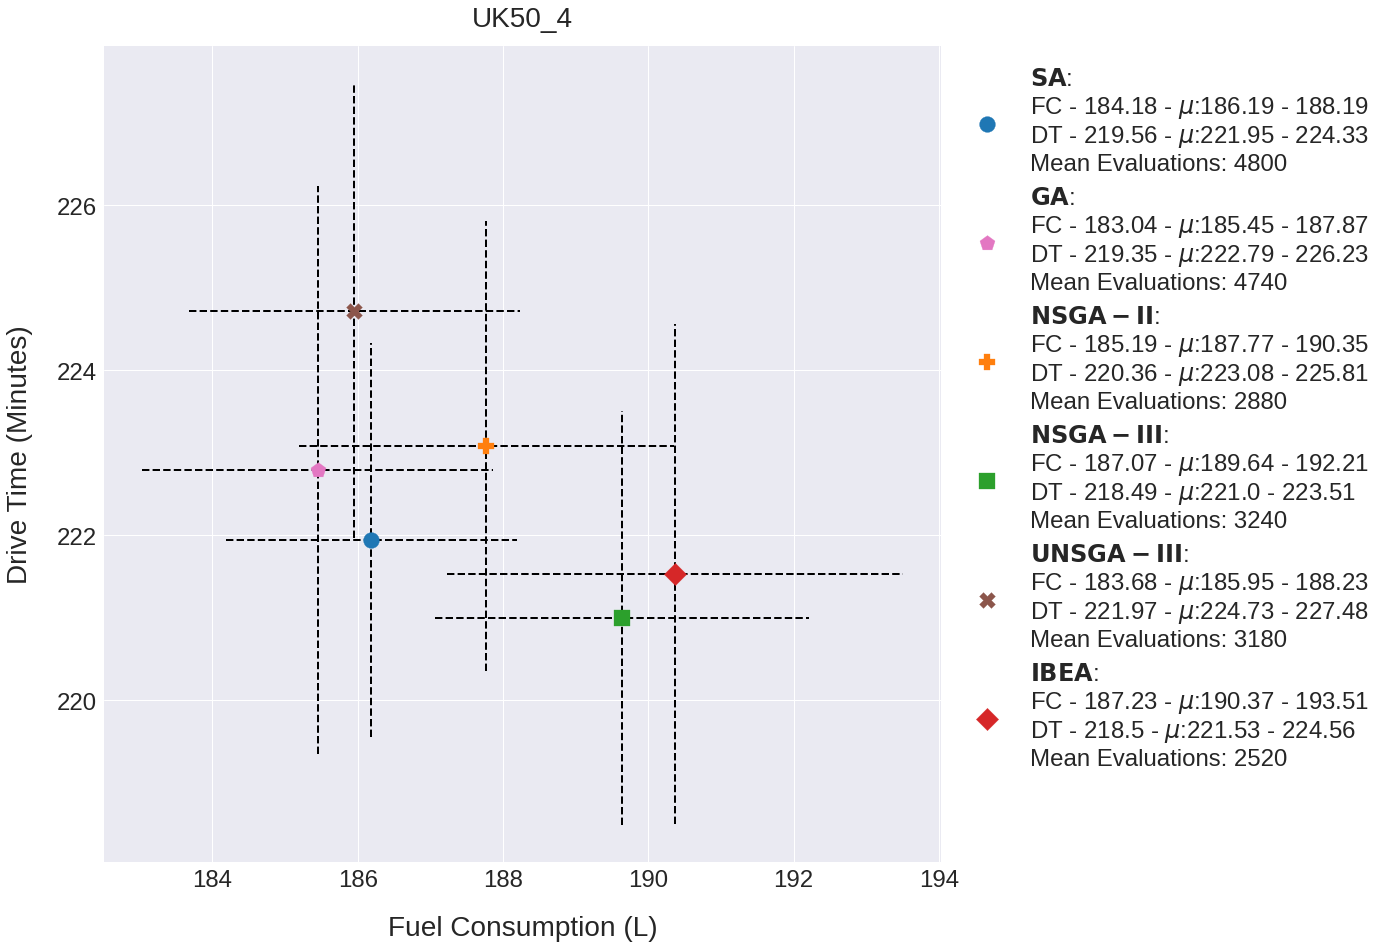

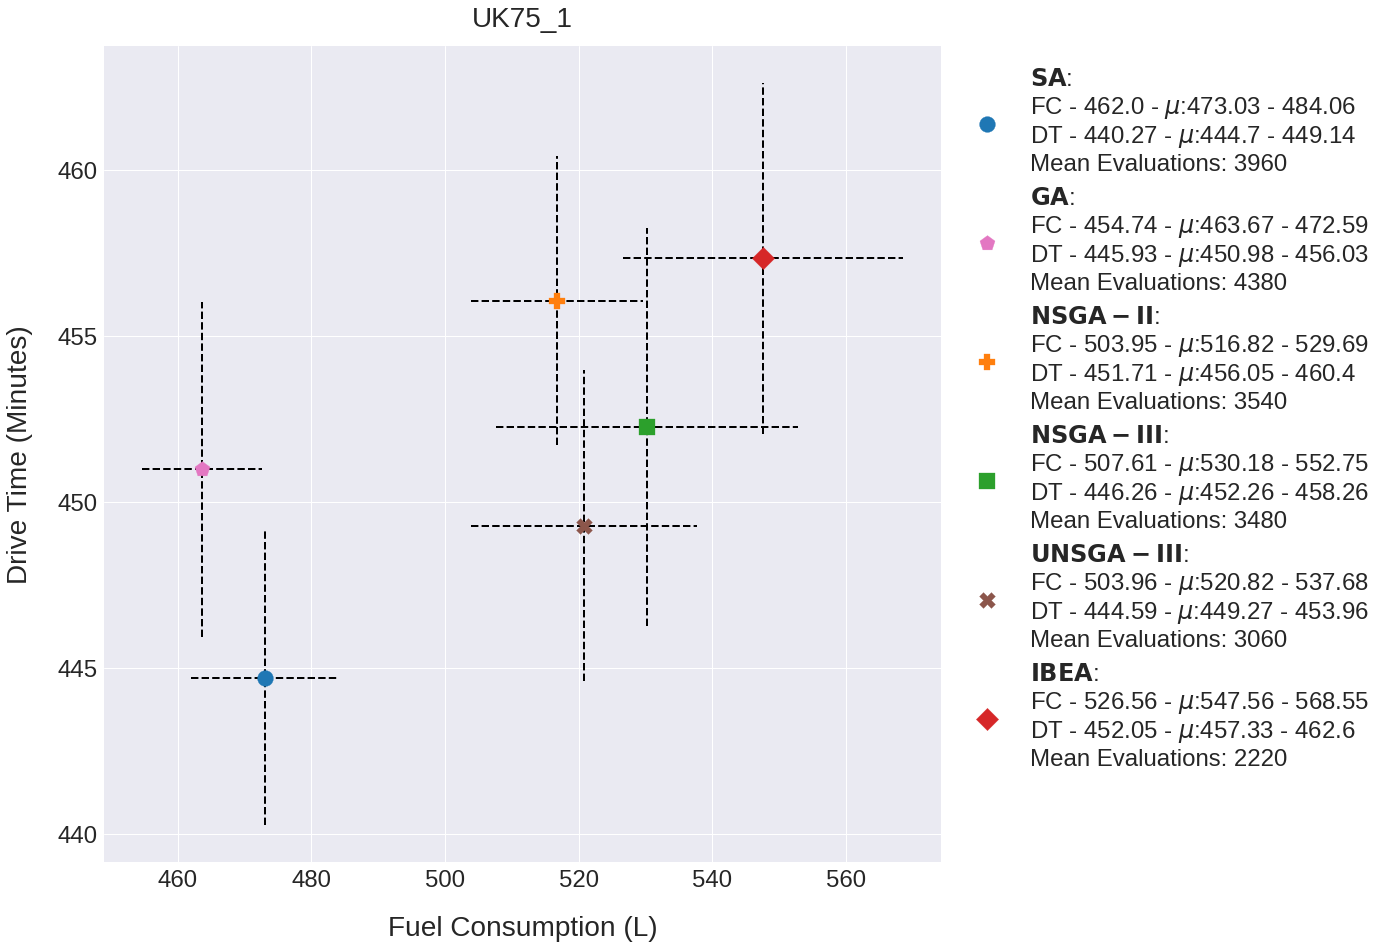

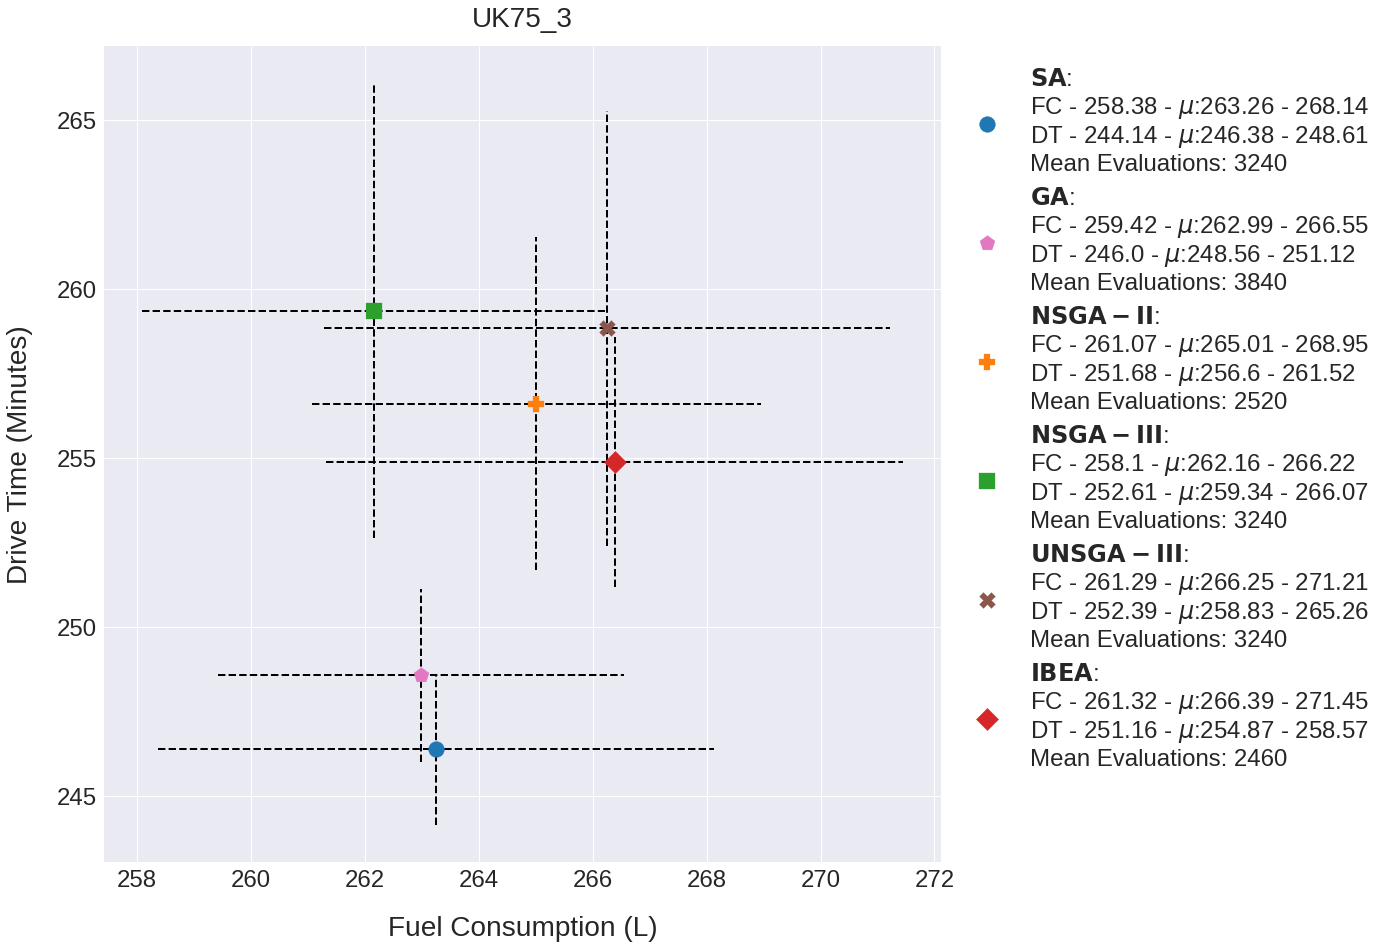

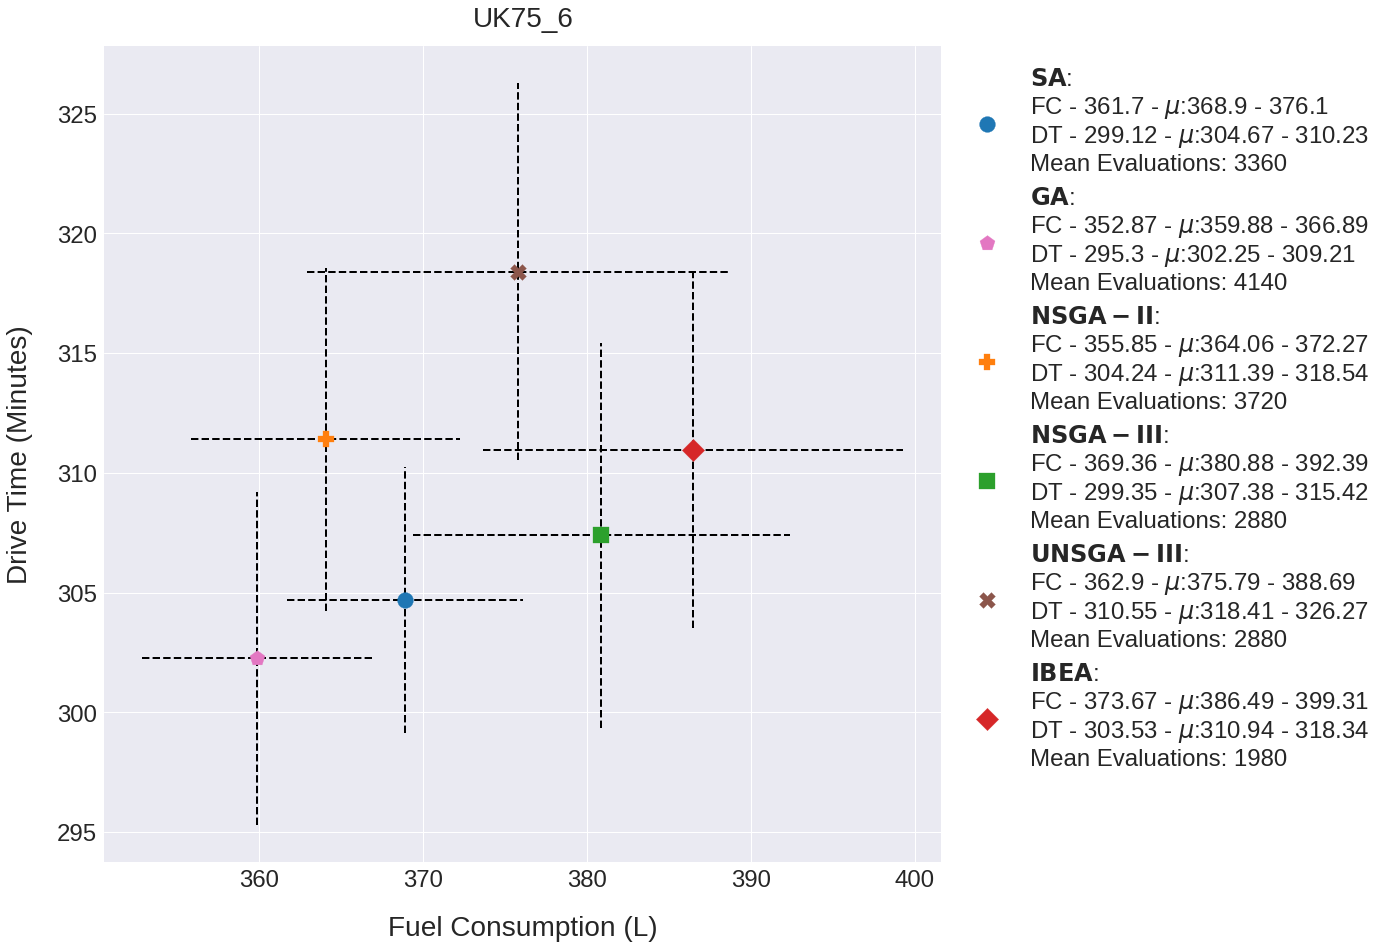

In [76]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
for dataset in dataset_names:
    SA_data_dataset = SA_data_time_limited.where(SA_data_time_limited.dataset == dataset).dropna(how="all").mean()
    GA_data_dataset = GA_data_time_limited.where(GA_data_time_limited.dataset == dataset).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data_time_limited.where(NSGA2_data_time_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_time_limited.where(NSGA3_data_time_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_time_limited.where(UNSGA3_data_time_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_time_limited.where(IBEA_data_time_limited.dataset == dataset).dropna(how="all").mean()

    algorithms = [SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]
    
    labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
    fig, ax = plot_2d_minmax_scaled(algorithms, labels,minmax_scale=False,show_mean_eval=True)
    

    
    
    plt.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
    
    
    
    plt.title(dataset)
    plt.show()

# Plot evaluation limited

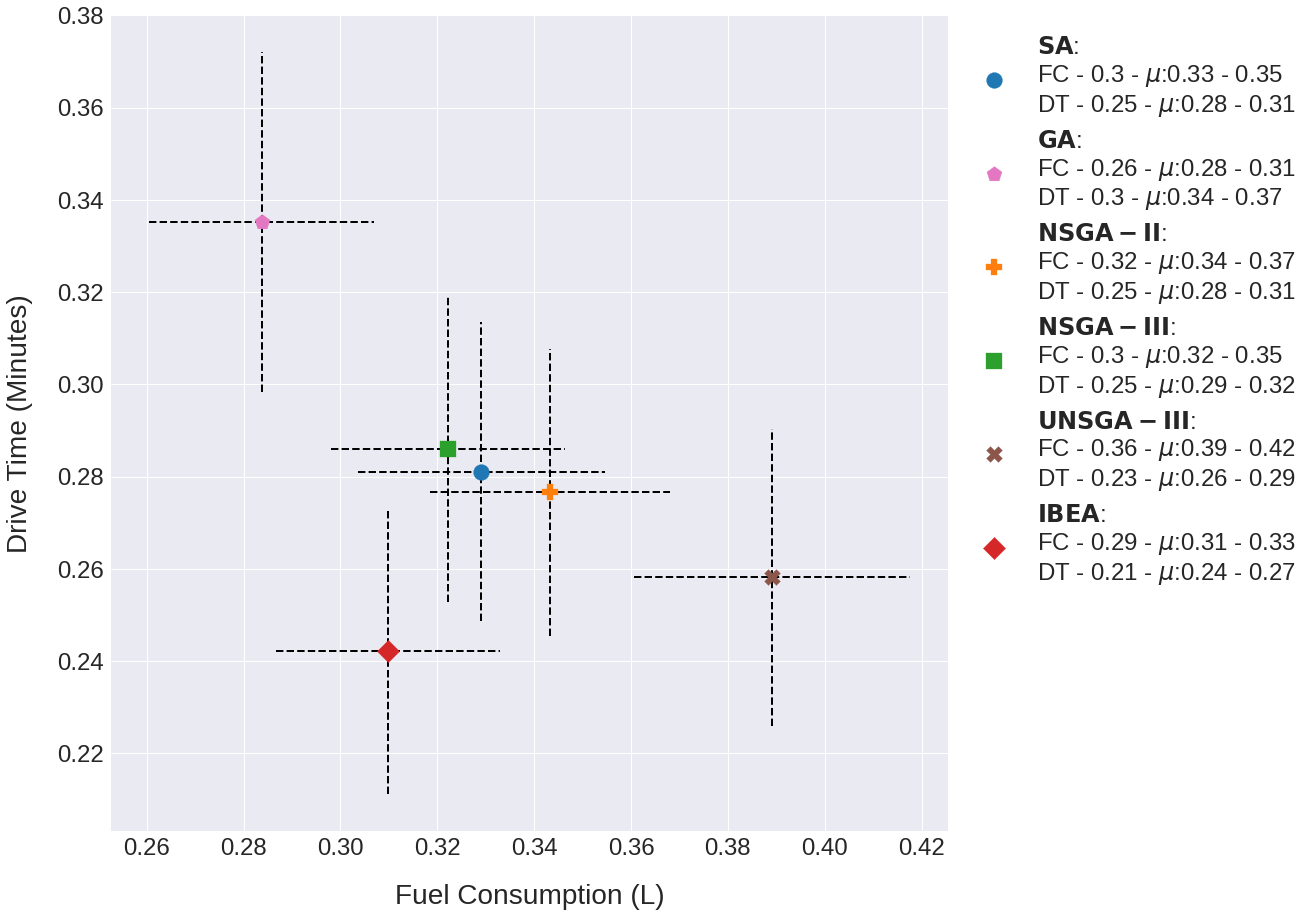

In [77]:
algorithms = [SA_data_evaluation_limited_mean, GA_data_evaluation_limited_mean, NSGA2_data_evaluation_limited_mean, NSGA3_data_evaluation_limited_mean, UNSGA3_data_evaluation_limited_mean, IBEA_data_evaluation_limited_mean]
labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
fig, ax = plot_2d_minmax_scaled(algorithms, labels)
plt.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
#plt.tight_layout(pad=2)
plt.show()

# Plot evaluation limited for all datasets

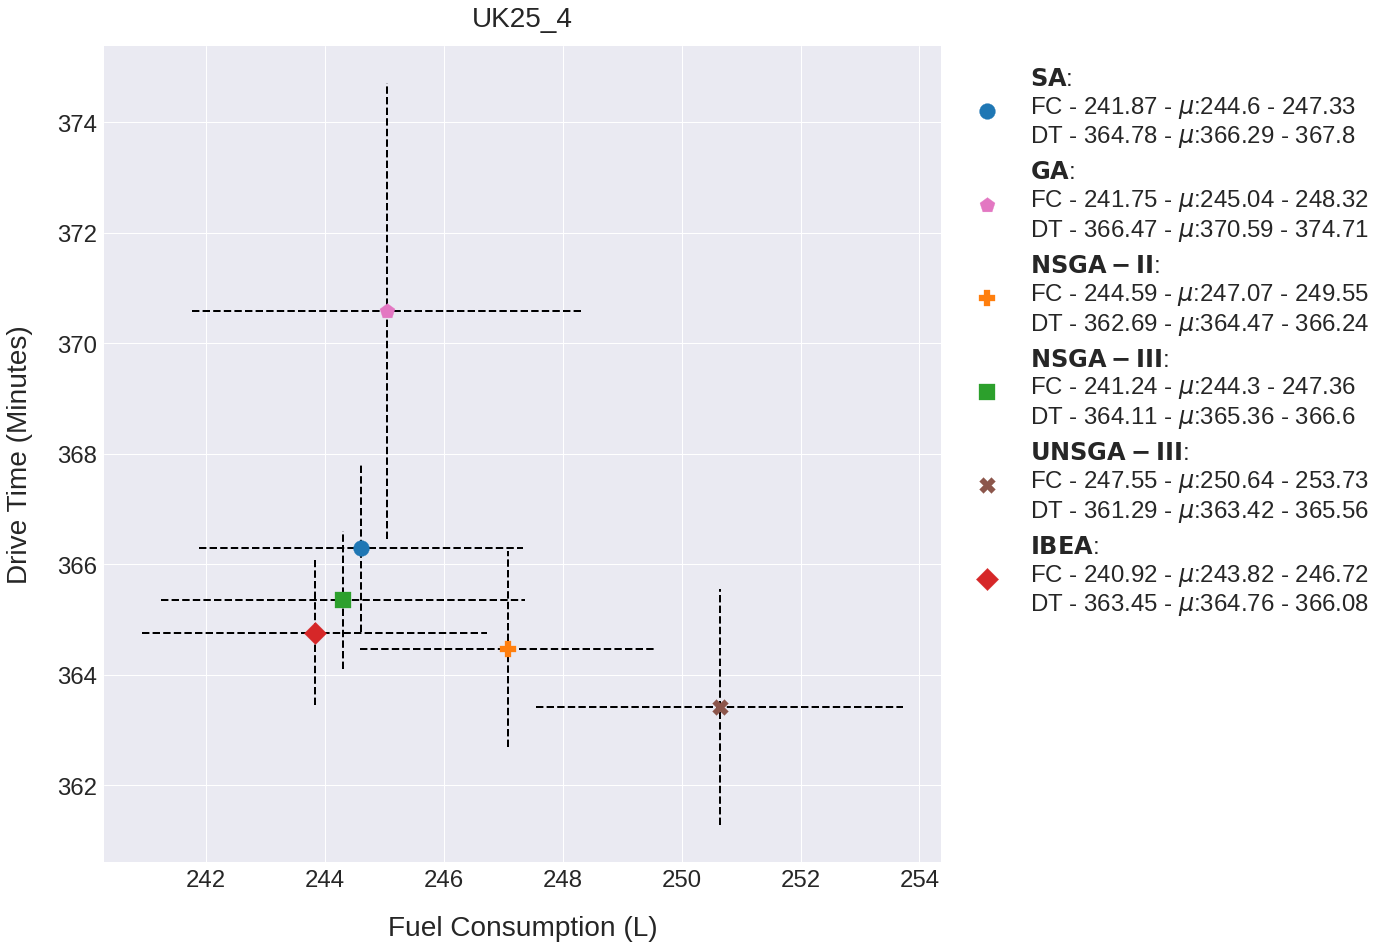

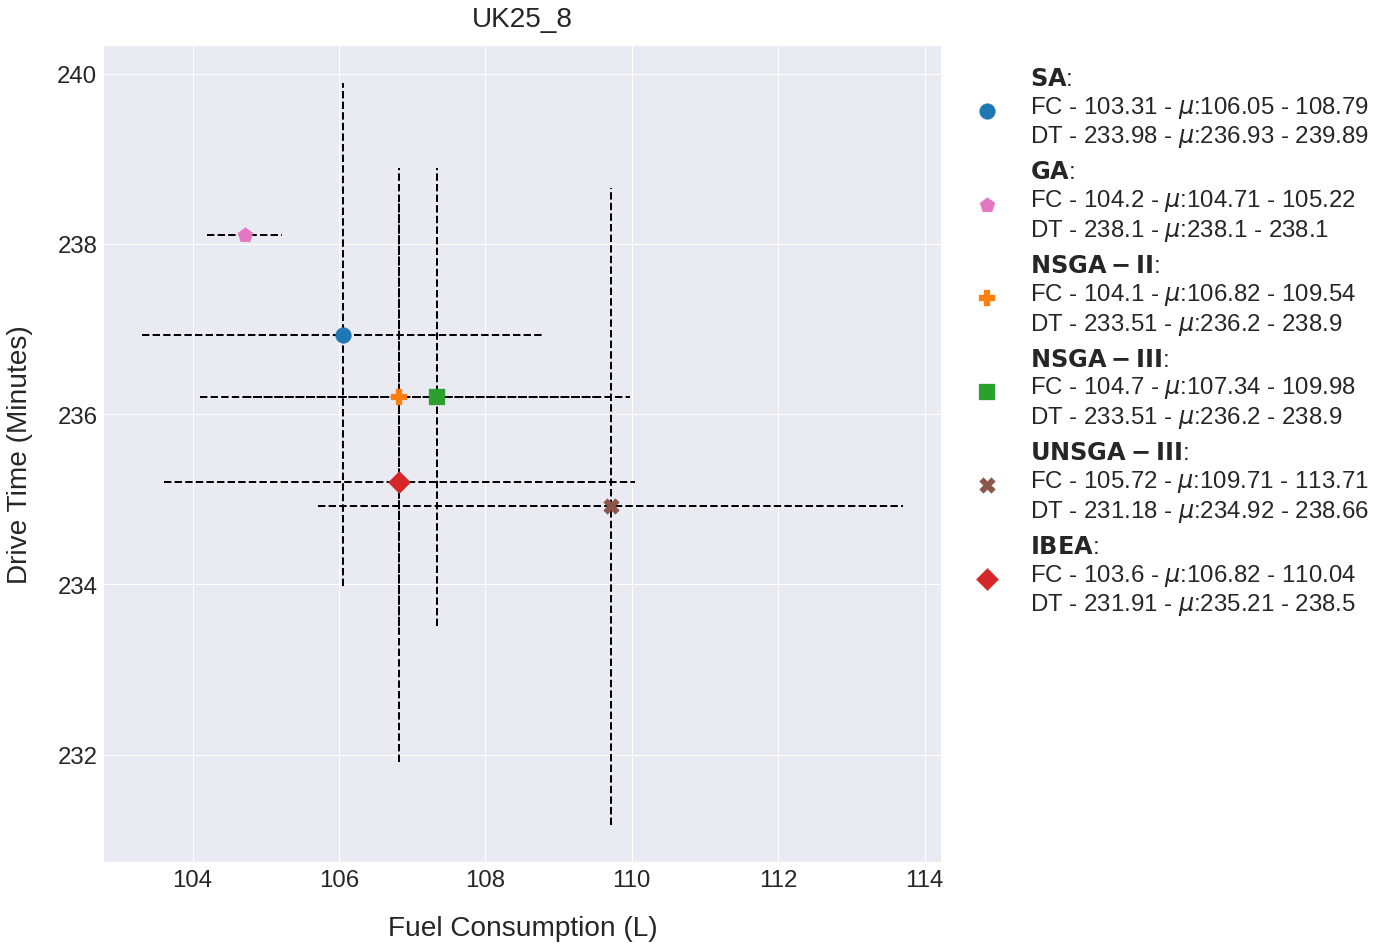

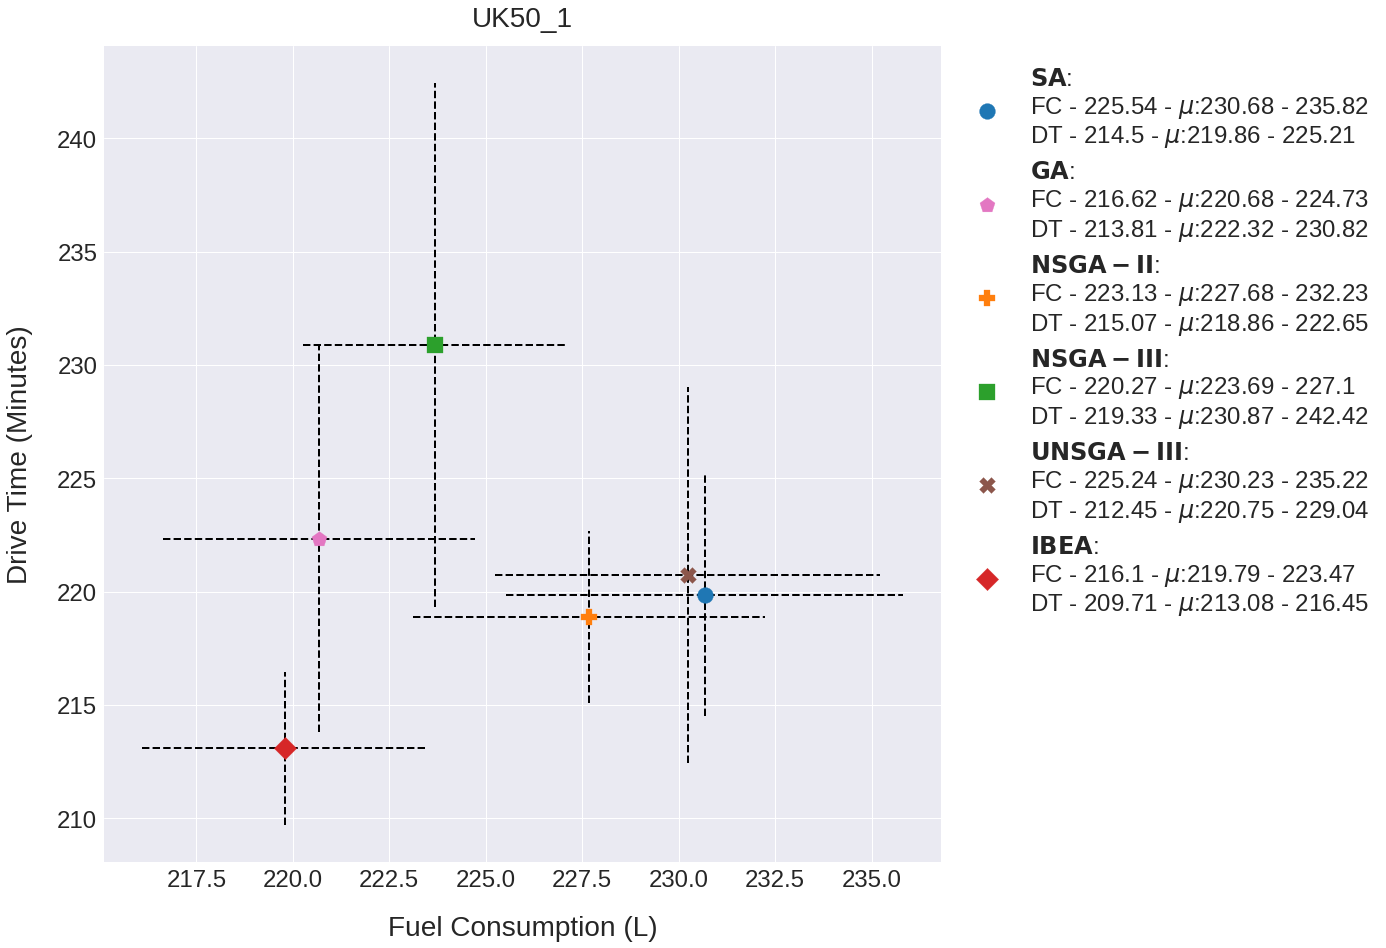

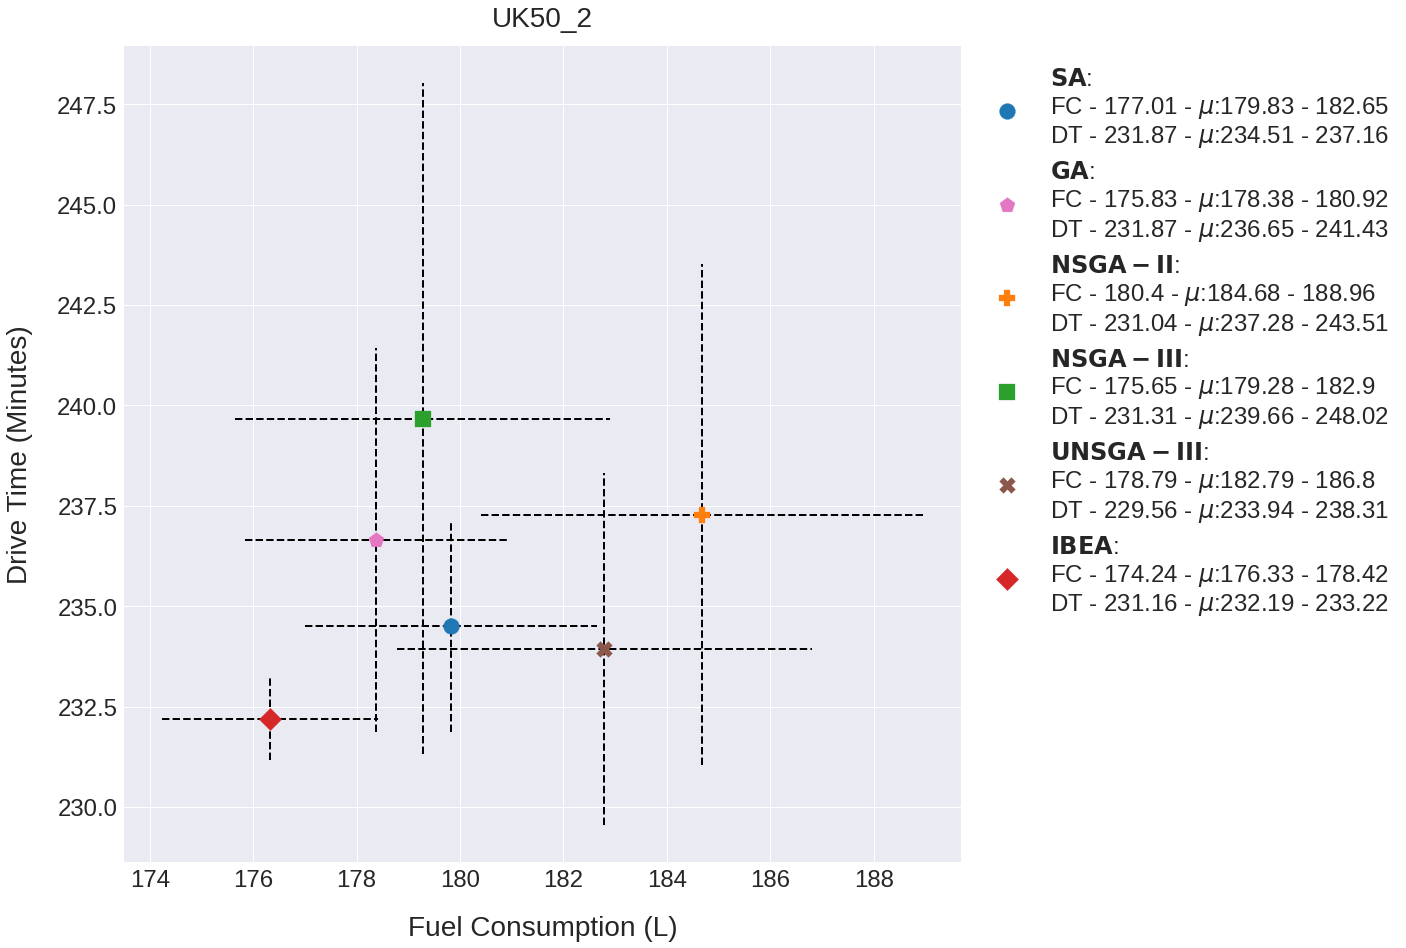

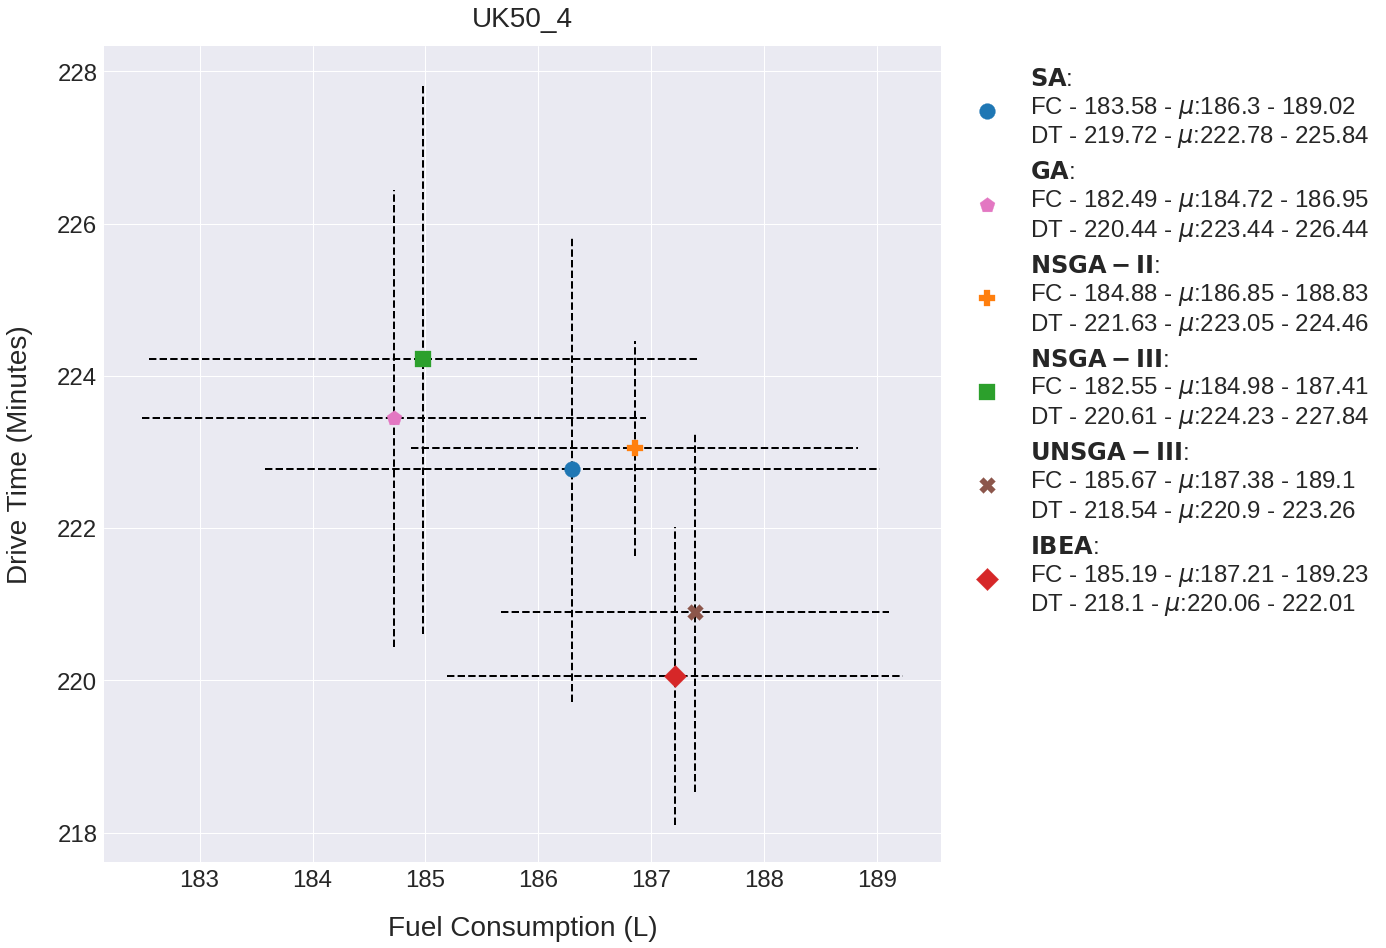

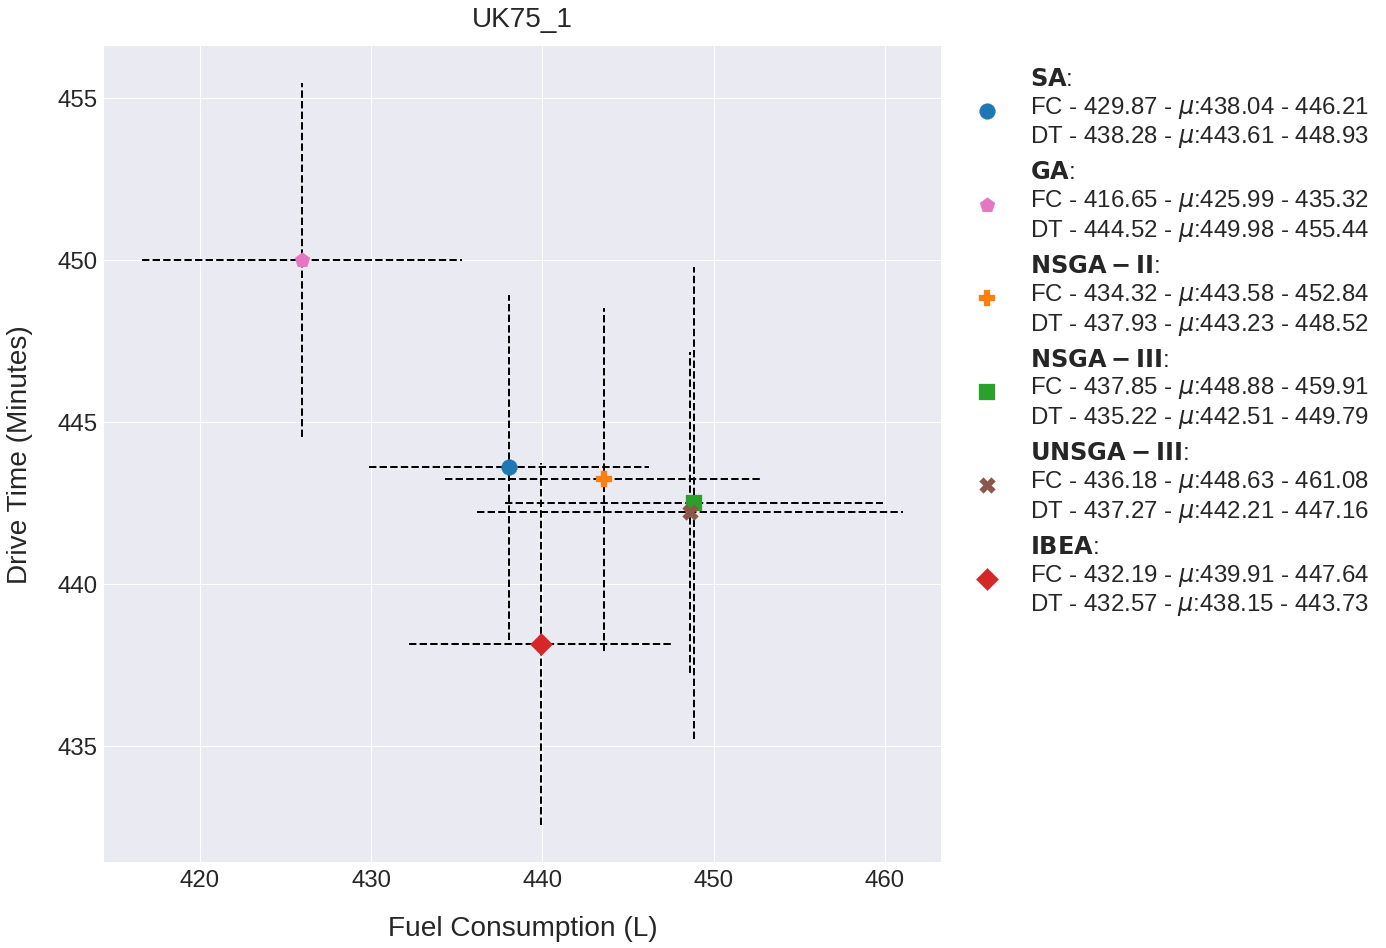

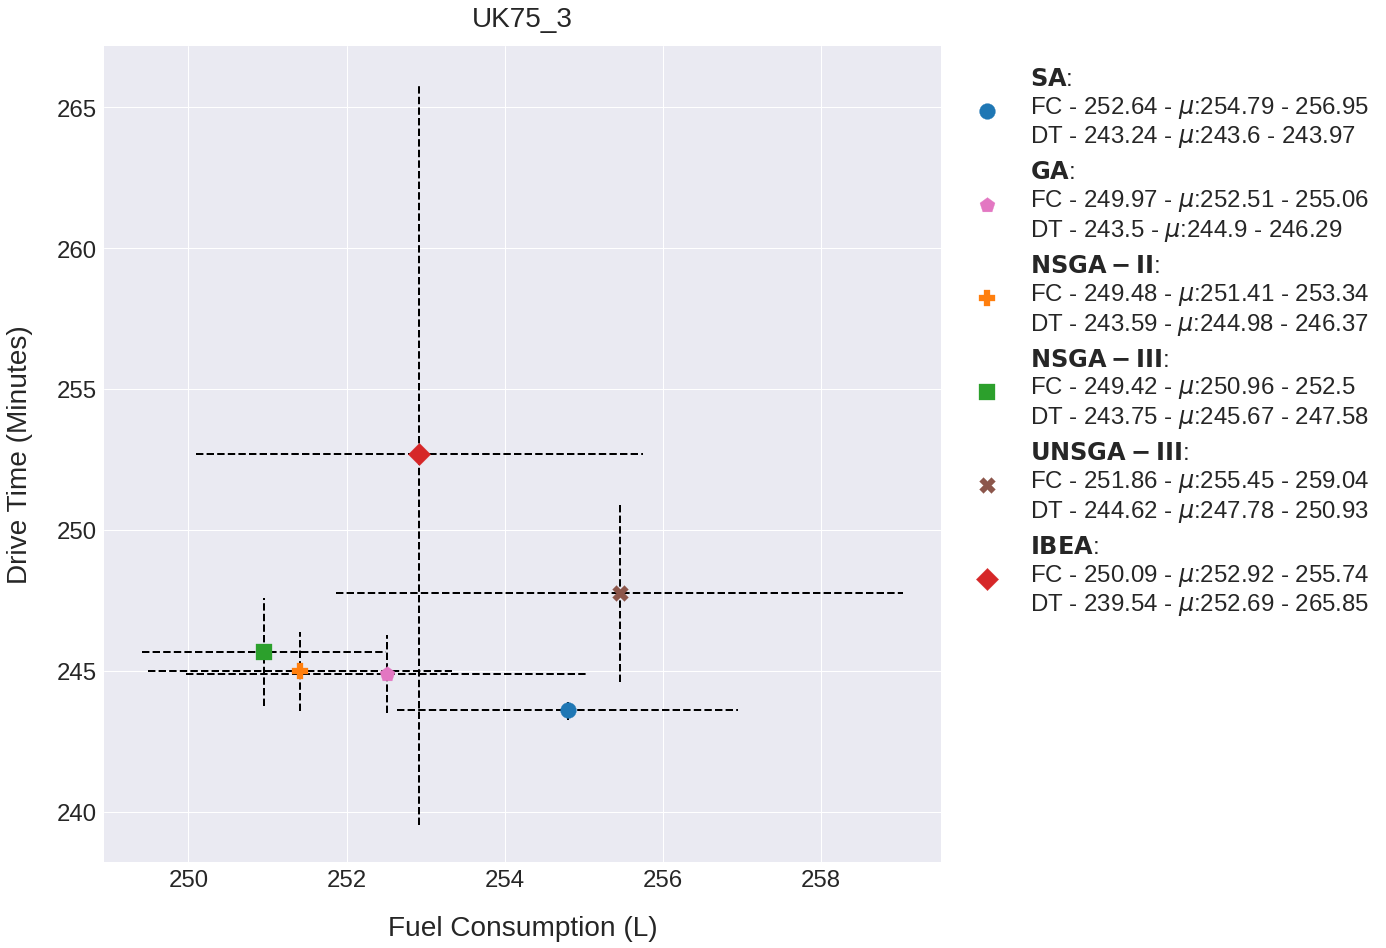

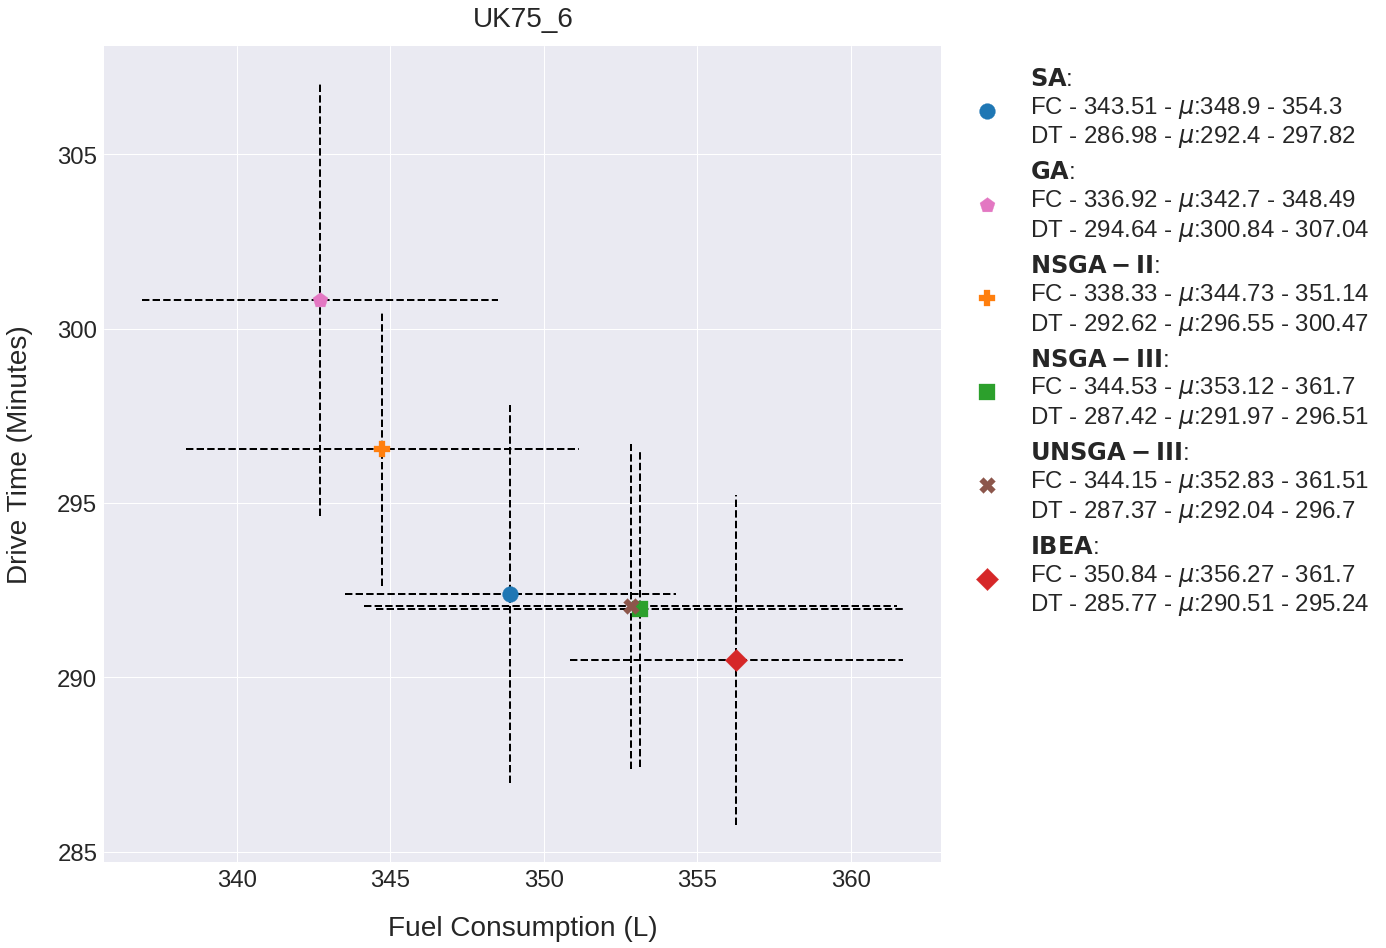

In [78]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    GA_data_dataset = GA_data_evaluation_limited.where(GA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()

    algorithms = [SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]
    
    
    fig, ax = plot_2d_minmax_scaled(algorithms, labels,minmax_scale=False)
    

    
    
    plt.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
    
    
    
    plt.title(dataset)
    plt.show()

# Plot evaluation limited divided into the three different dataset sizes

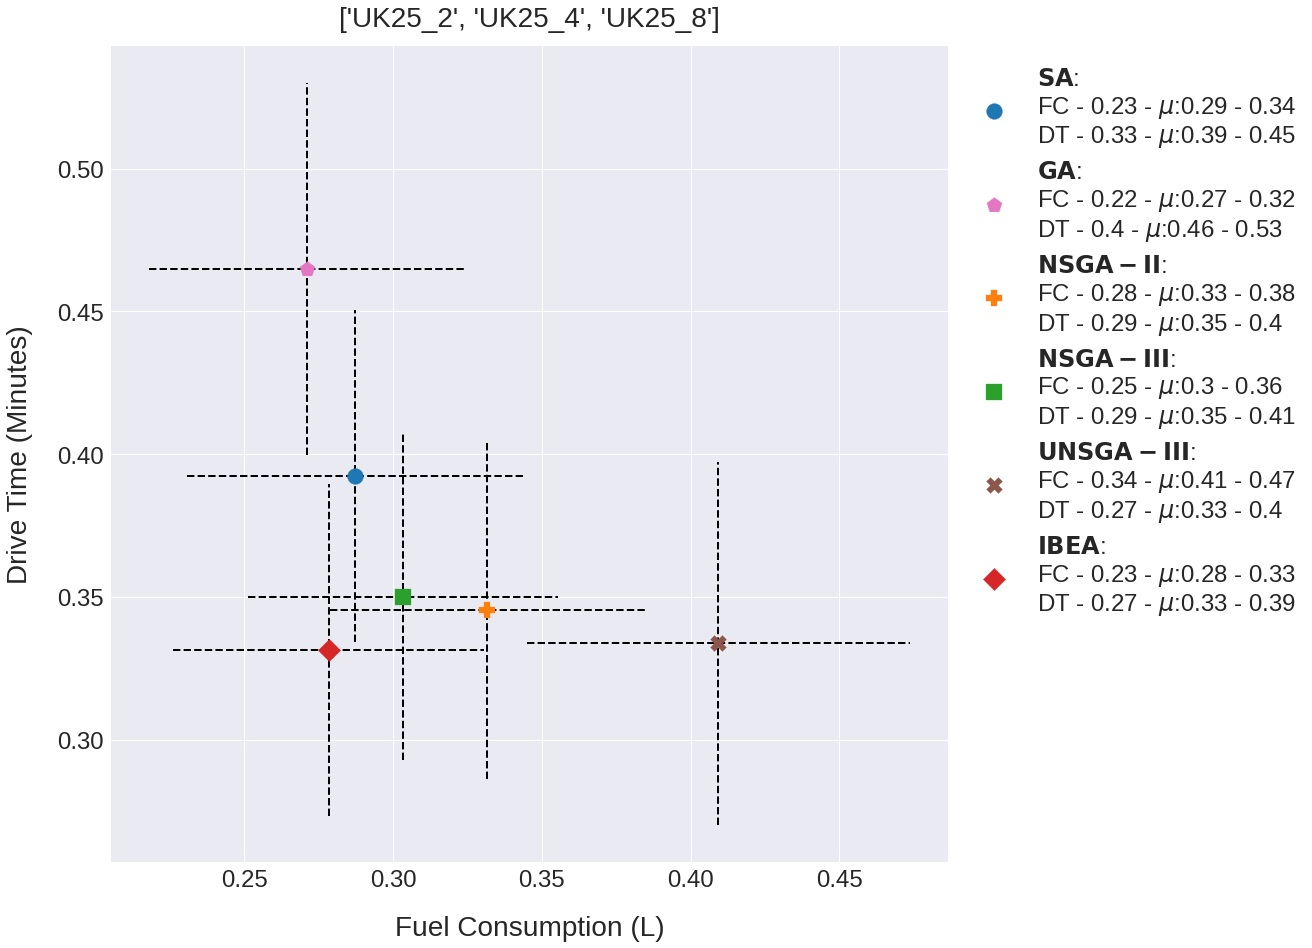

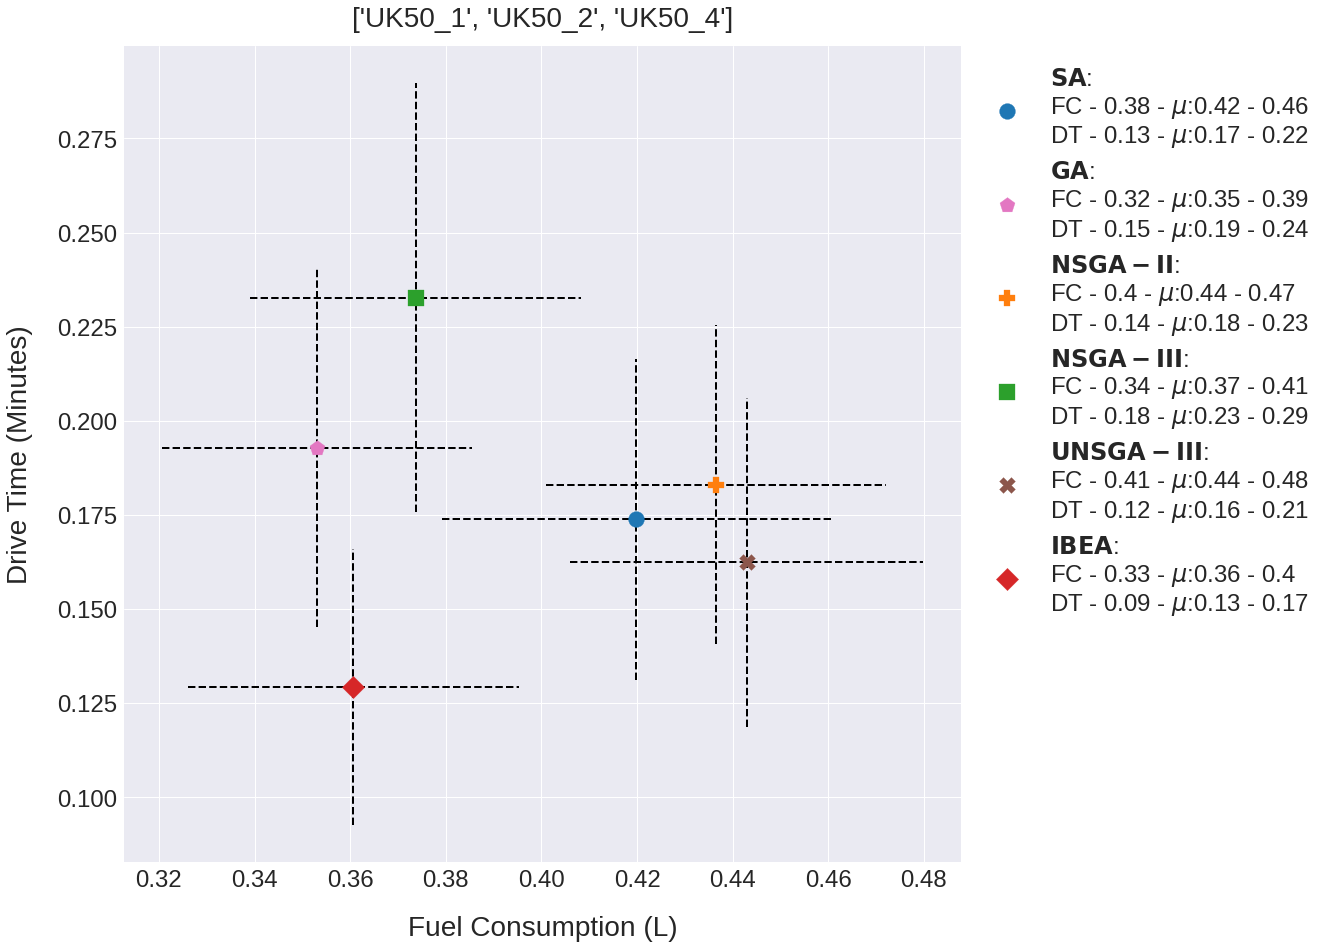

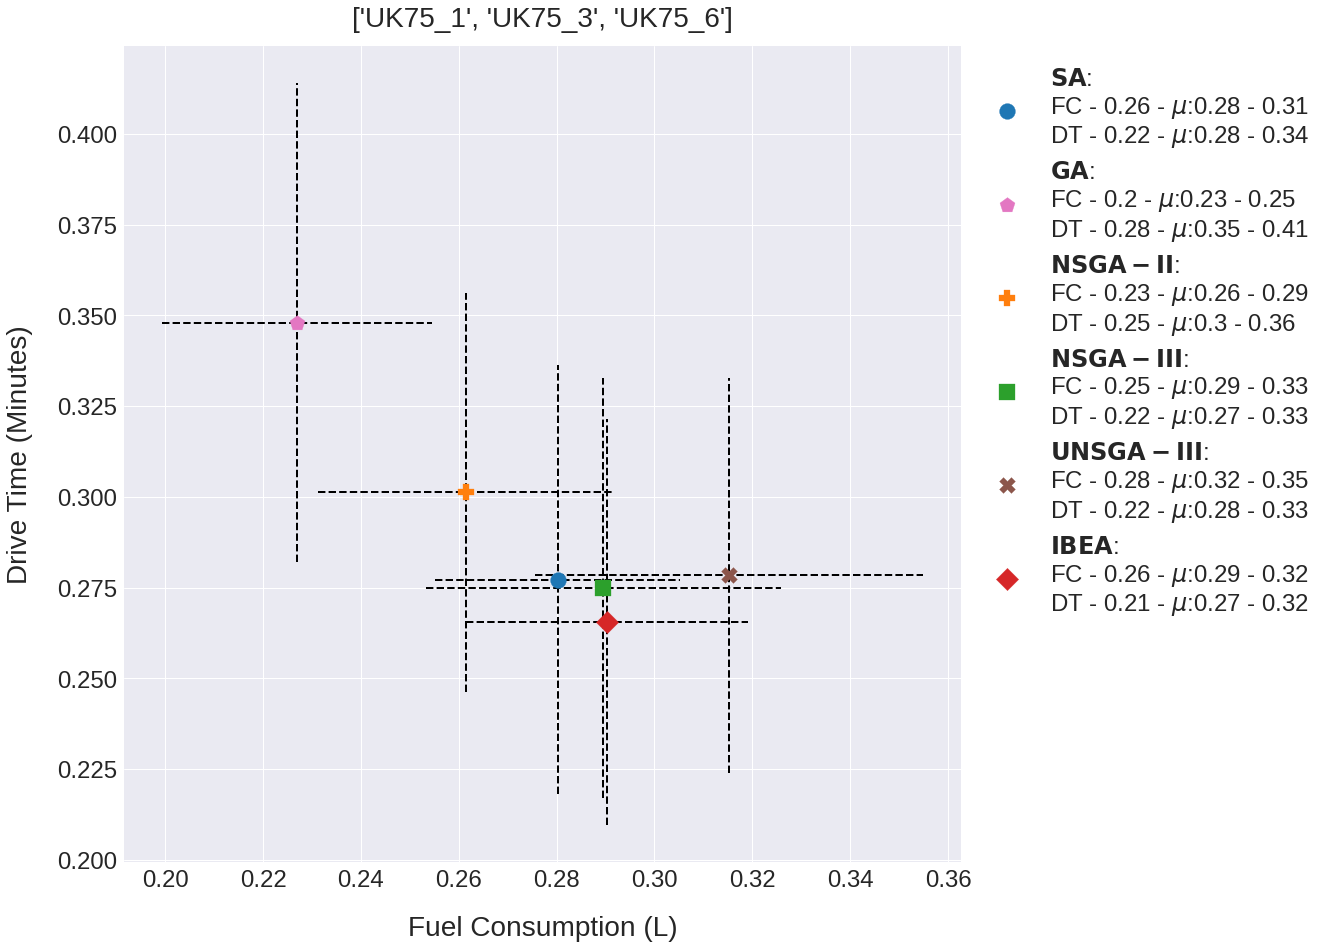

In [79]:

dataset_names =  [["UK25_2", "UK25_4", "UK25_8"],[ "UK50_1", "UK50_2", "UK50_4"],[ "UK75_1","UK75_3","UK75_6"]]
for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all")#.mean()
    GA_data_dataset = GA_data_evaluation_limited.where(GA_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all")#.mean()
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all")#.mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all")#.mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all")#.mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all")#.mean()
    
    
    
    
    
    algorithms = [SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]
    
    add_minmax_fuel_drivetime_columns(algorithms,dataset)
    
    SA_data_dataset = SA_data_dataset.mean()
    GA_data_dataset = GA_data_dataset.mean()
    NSGA2_data_dataset = NSGA2_data_dataset.mean()
    NSGA3_data_dataset = NSGA3_data_dataset.mean()
    UNSGA3_data_dataset = UNSGA3_data_dataset.mean()
    IBEA_data_dataset = IBEA_data_dataset.mean()
    
    algorithms = [SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]
    
    fig, ax = plot_2d_minmax_scaled(algorithms, labels)
    

    
    
    plt.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
    
    
    
    plt.title(dataset)
    plt.show()

# Compare Normal vs Pickup and Drop solution (evaluation limited)

In [81]:
import time 
start_time = time.monotonic()
print("SA")

SA_data_evaluation_limited_copy = deepcopy(SA_data_evaluation_limited)
NSGA3_data_evaluation_limited_copy = deepcopy(NSGA3_data_evaluation_limited)
IBEA_data_evaluation_limited_copy = deepcopy(IBEA_data_evaluation_limited)

SA_pickup_and_drop = combine_datasets("SA_pick_and_drop", "parameter_data/pick_and_drop_results/")

print("NSGA3")
NSGA3_pickup_and_drop = combine_datasets("NSGAIII_pick_and_drop", "parameter_data/pick_and_drop_results/")

print("IBEA")
IBEA_pickup_and_drop = combine_datasets("IBEA_pick_and_drop", "parameter_data/pick_and_drop_results/")

add_minmax_fuel_drivetime_columns([SA_data_evaluation_limited_copy,SA_pickup_and_drop,
                                   NSGA3_data_evaluation_limited_copy,NSGA3_pickup_and_drop,
                                   IBEA_data_evaluation_limited_copy,IBEA_pickup_and_drop])

SA_data_evaluation_limited_copy_mean = SA_data_evaluation_limited_copy.mean()
NSGA3_data_evaluation_limited_copy_mean = NSGA3_data_evaluation_limited_copy.mean()
IBEA_data_evaluation_limited_copy_mean = IBEA_data_evaluation_limited_copy.mean()
SA_pickup_and_drop_mean = SA_pickup_and_drop.mean()
NSGA3_pickup_and_drop_mean = NSGA3_pickup_and_drop.mean()
IBEA_pickup_and_drop_mean = IBEA_pickup_and_drop.mean()
print("Time: ", time.monotonic() - start_time)

SA
NSGA3
IBEA
Time:  2.268155817000661


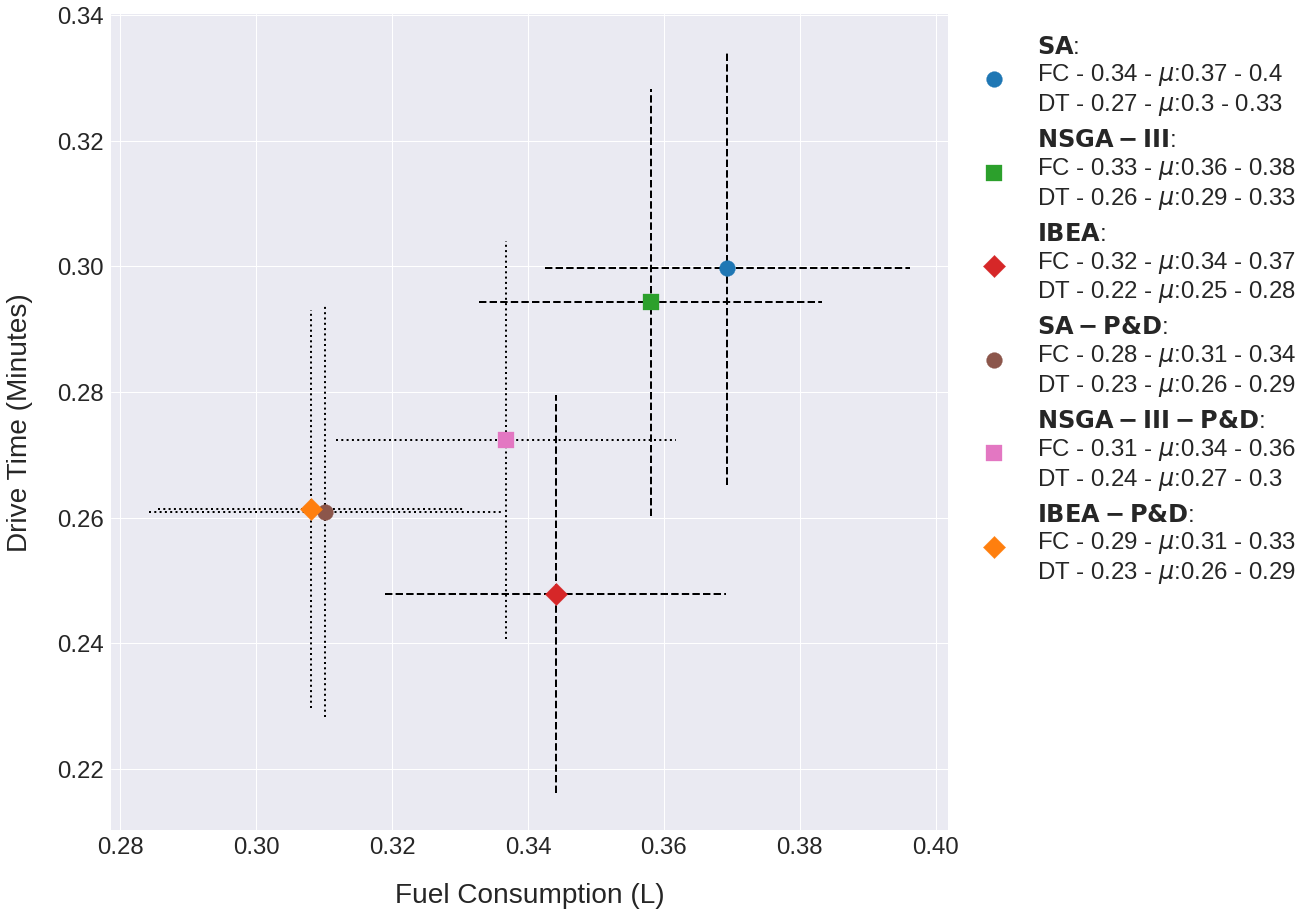

In [83]:
algorithms = [SA_data_evaluation_limited_copy_mean, NSGA3_data_evaluation_limited_copy_mean, IBEA_data_evaluation_limited_copy_mean
              , SA_pickup_and_drop_mean, NSGA3_pickup_and_drop_mean, IBEA_pickup_and_drop_mean]
labels =  ["SA", "NSGA-III","IBEA" ,"SA-P&D", "NSGA-III-P&D","IBEA-P&D" ]
fig, ax = plot_2d_minmax_scaled(algorithms, labels)
plt.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
#plt.tight_layout(pad=2)
plt.show()

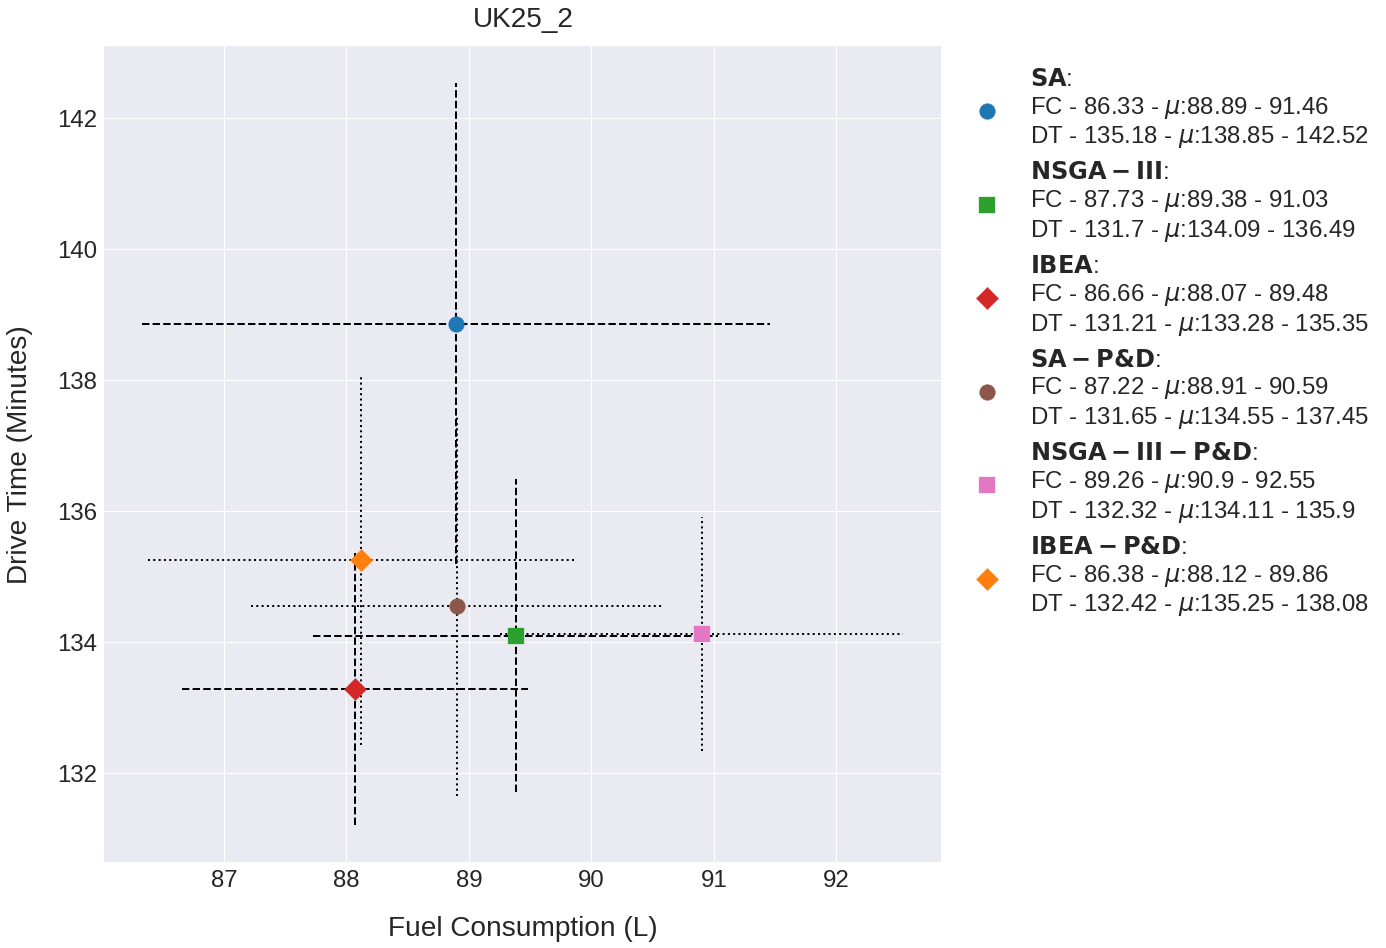

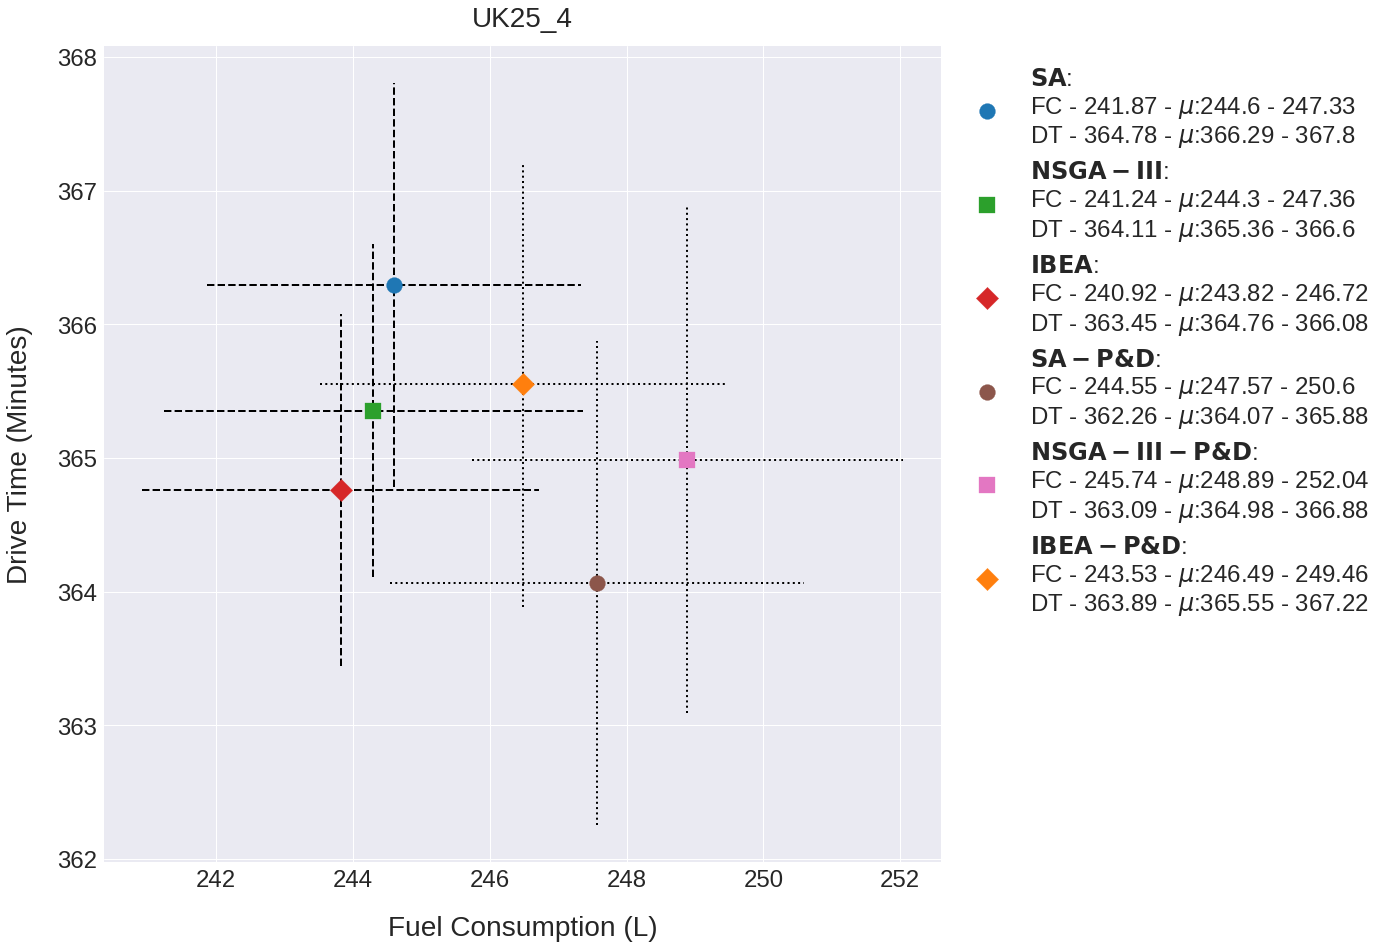

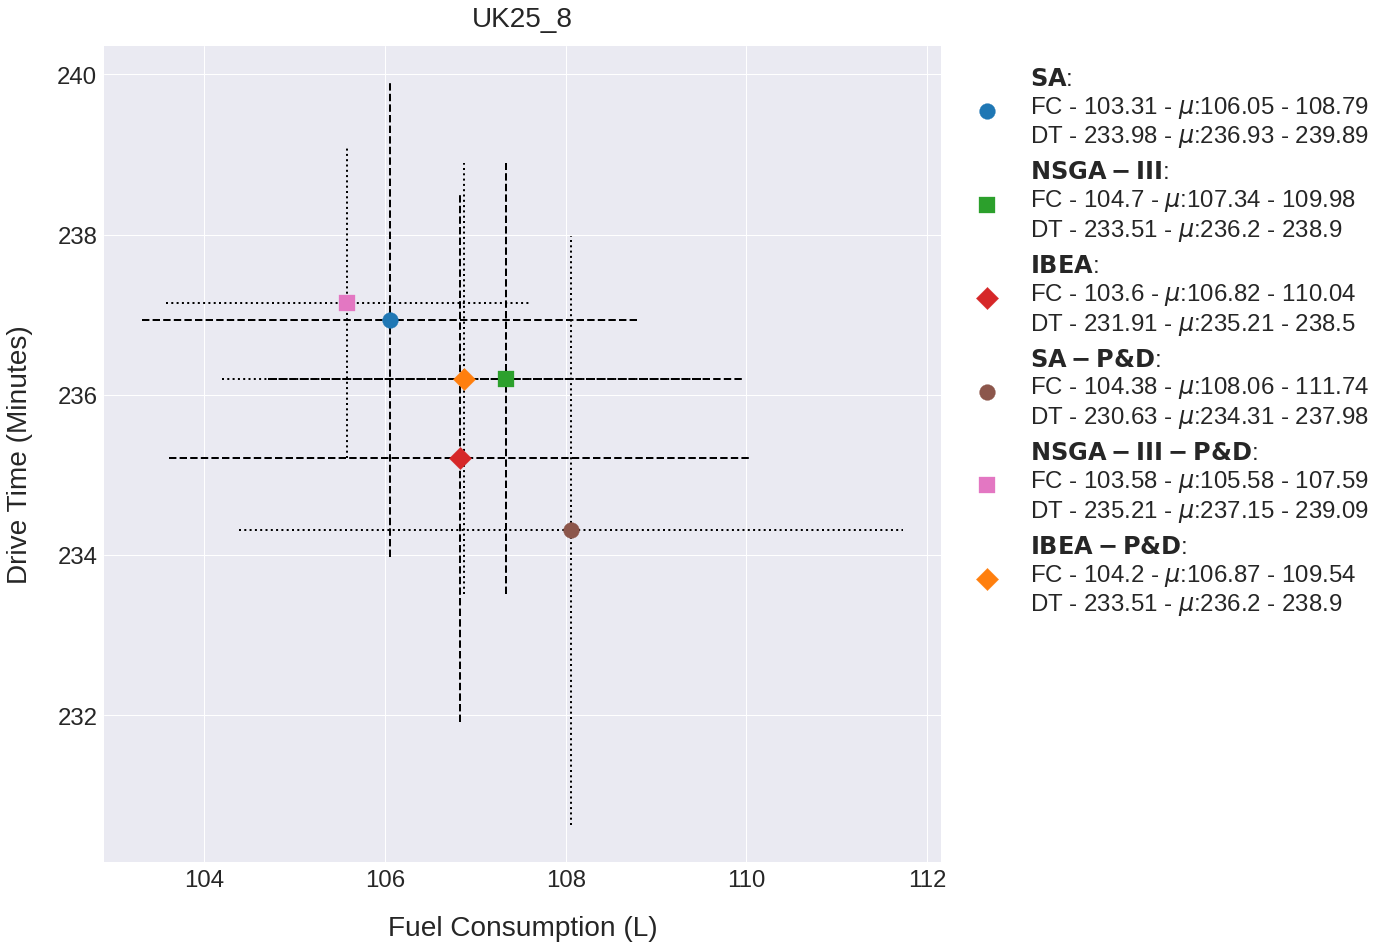

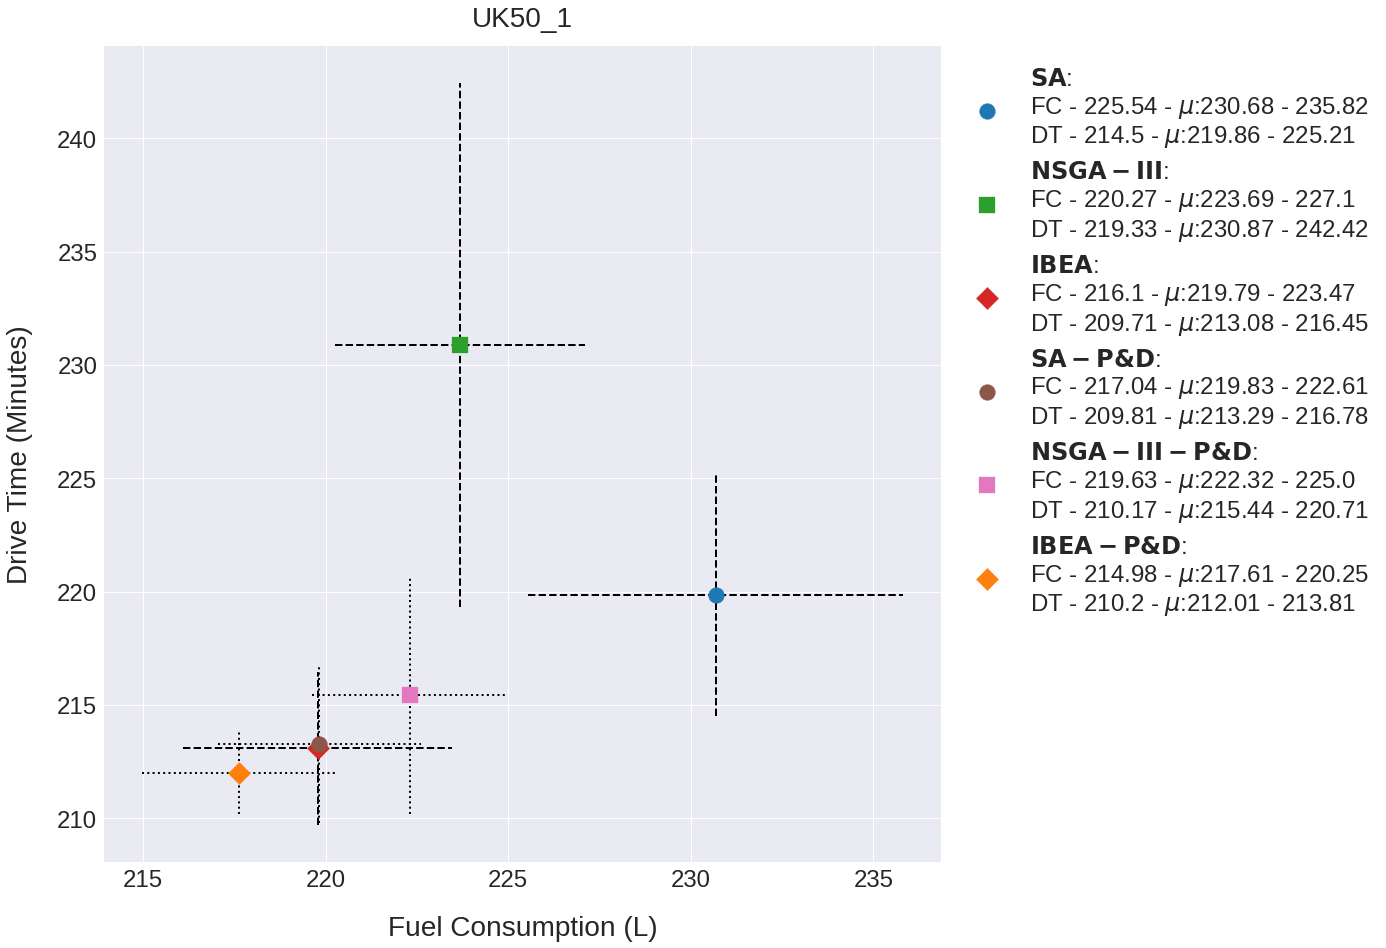

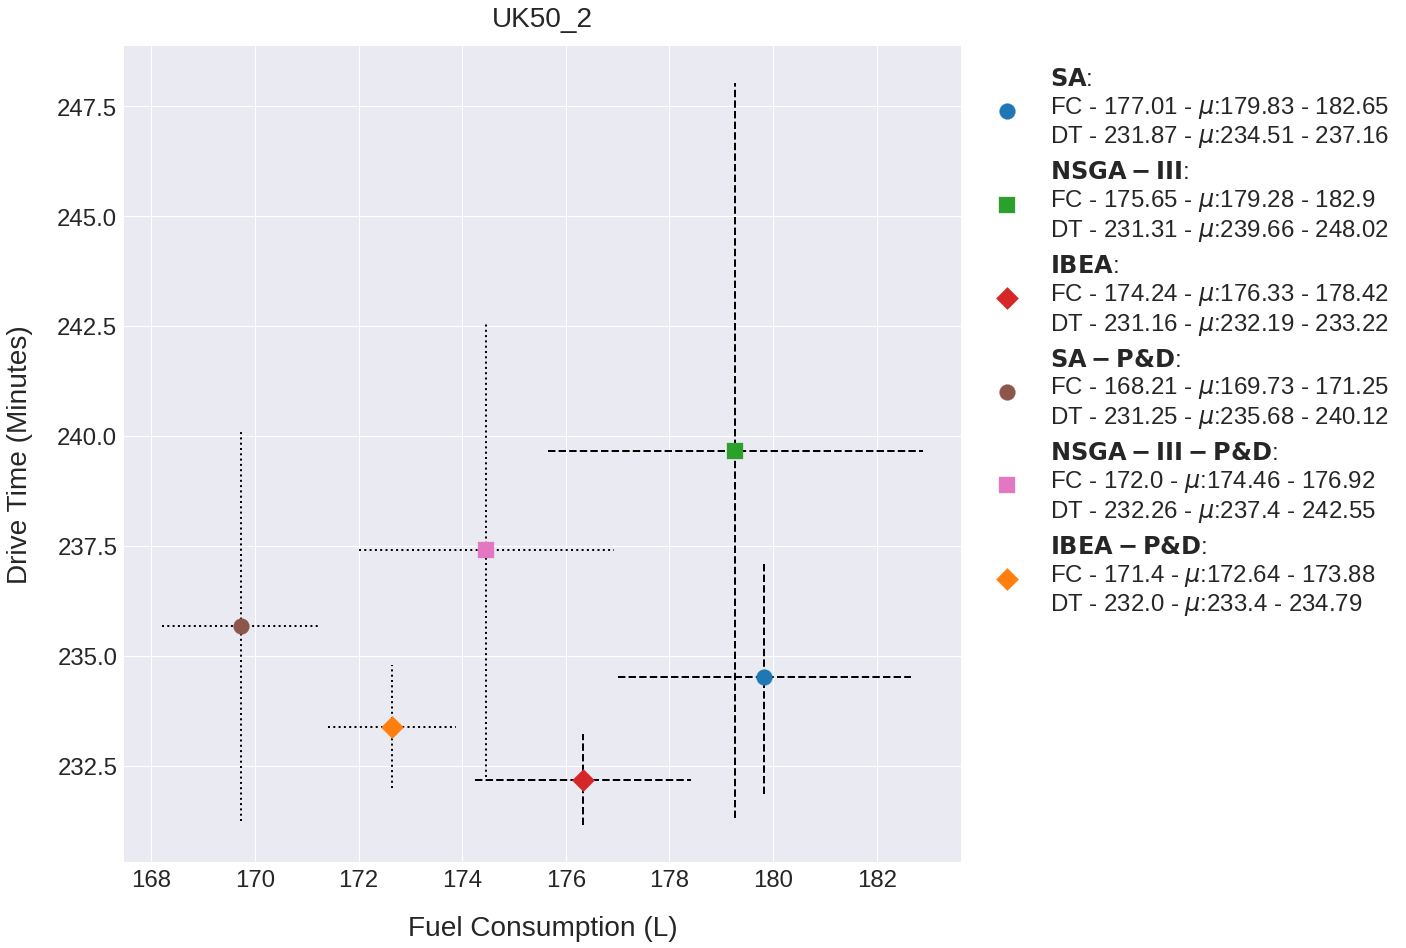

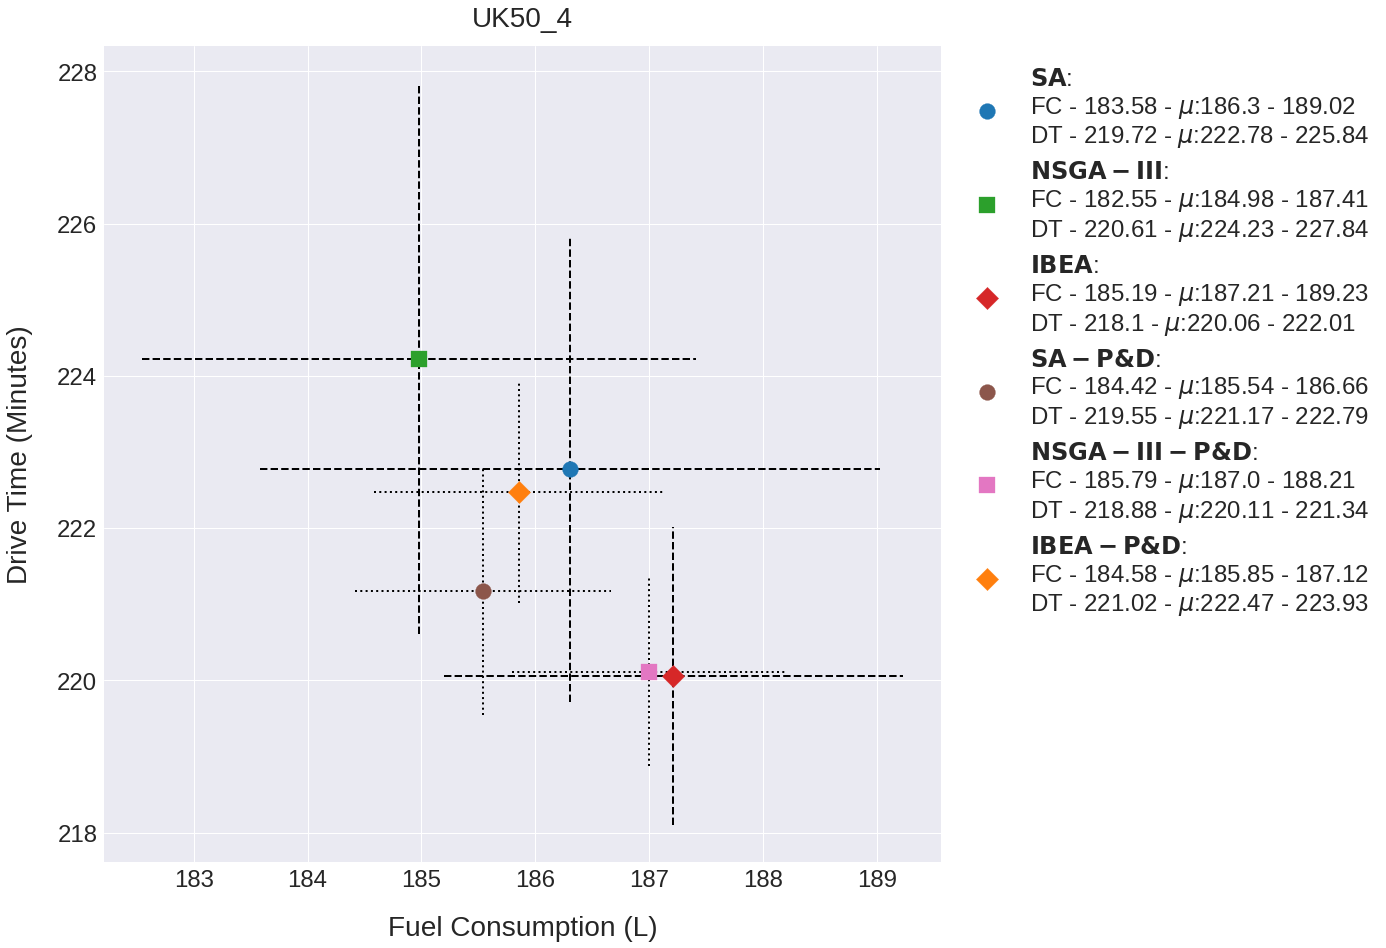

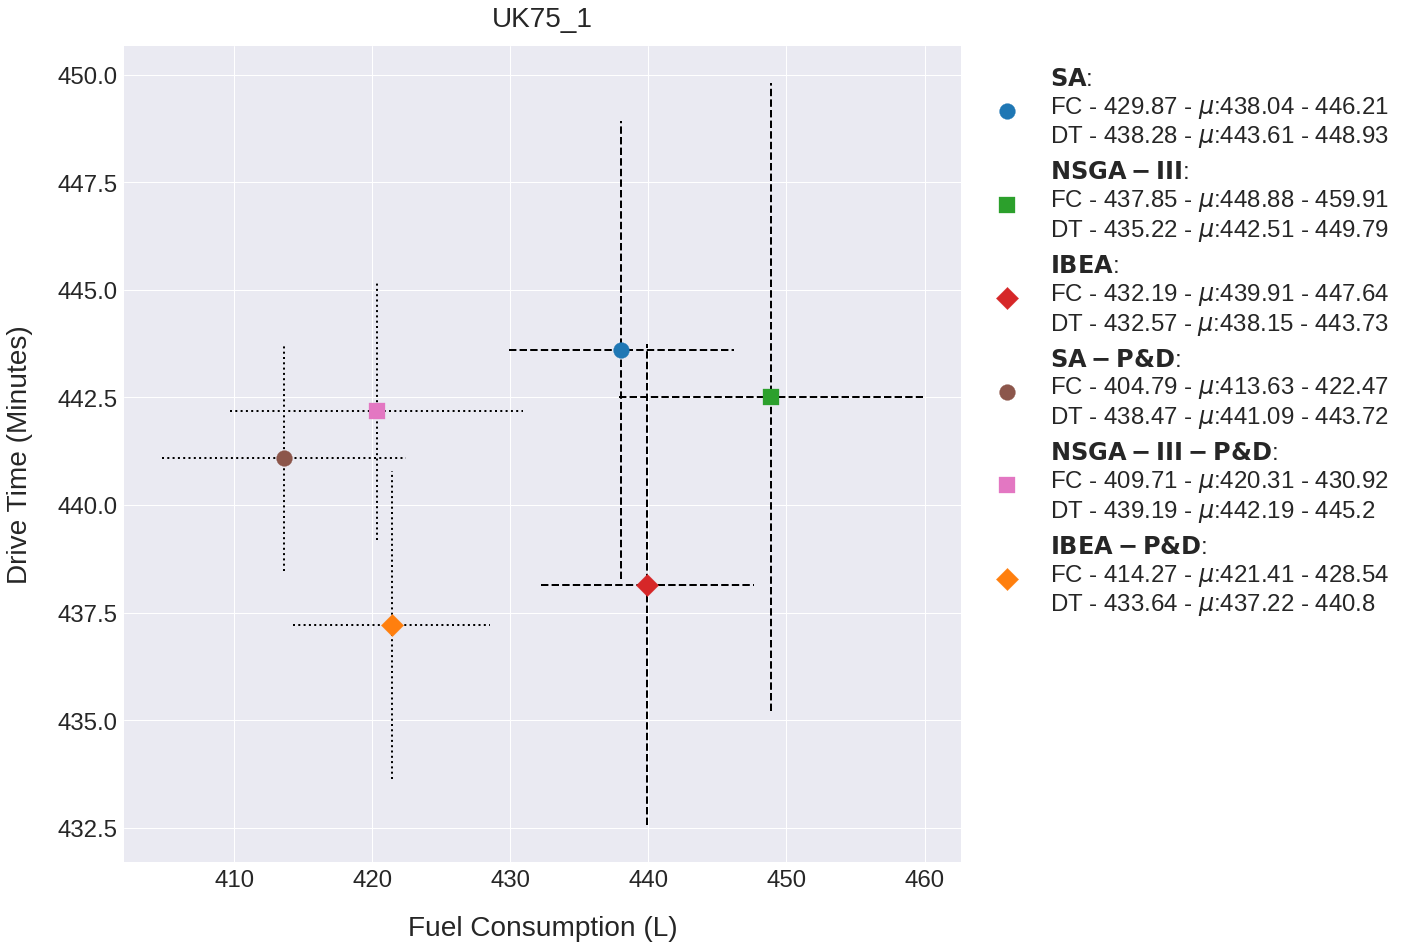

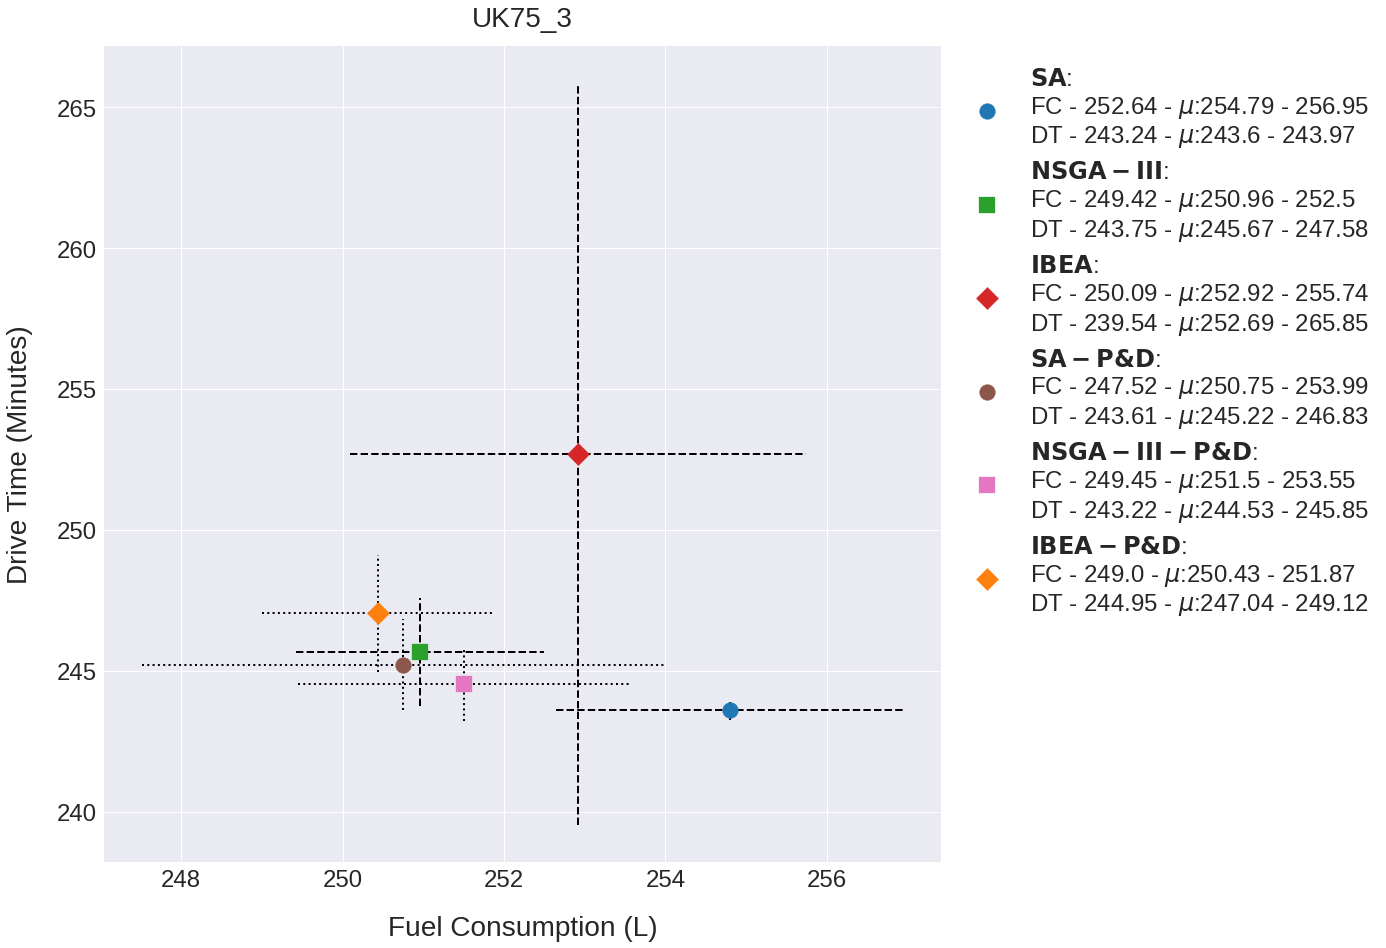

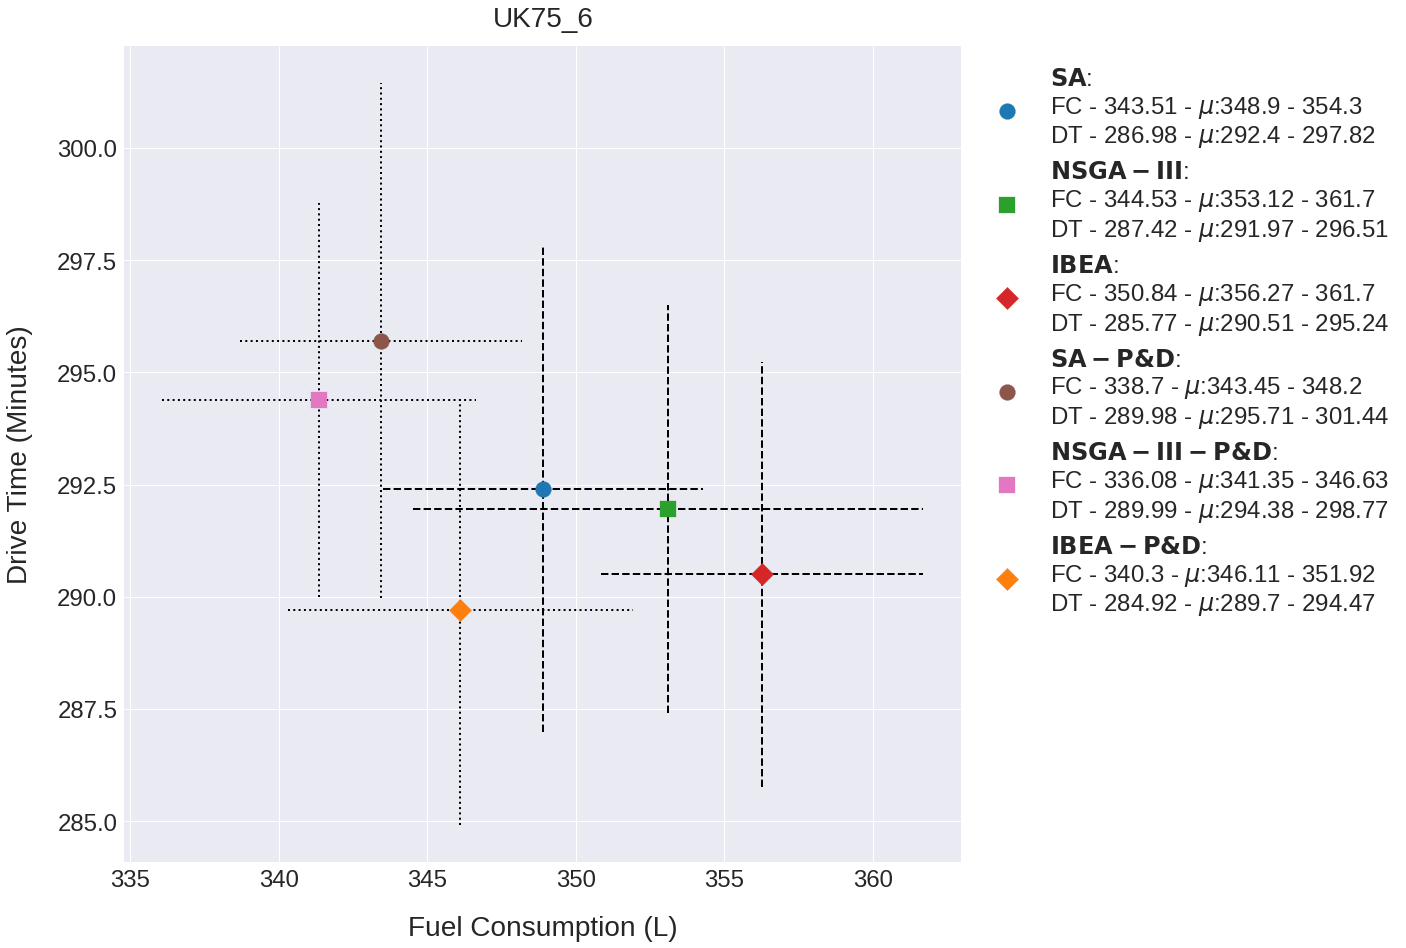

In [82]:
for dataset in ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]:
    SA_data_evaluation_limited_unique = combine_datasets("SA", "parameter_data/reruns/", dataset)

    IBEA_data_evaluation_limited_unique = combine_datasets("IBEA", "parameter_data/reruns_L1/", dataset)
    NSGA3_data_evaluation_limited_unique = combine_datasets("NSGA3", "parameter_data/reruns_L1/", dataset)
    
    SA_pickup_and_drop = combine_datasets("SA_pick_and_drop", "parameter_data/pick_and_drop_results/", dataset)
    IBEA_pickup_and_drop = combine_datasets("IBEA_pick_and_drop", "parameter_data/pick_and_drop_results/", dataset)
    NSGA3_pickup_and_drop = combine_datasets("NSGAIII_pick_and_drop", "parameter_data/pick_and_drop_results/", dataset)
    algorithms = [SA_data_evaluation_limited_unique, NSGA3_data_evaluation_limited_unique,IBEA_data_evaluation_limited_unique,SA_pickup_and_drop,NSGA3_pickup_and_drop,IBEA_pickup_and_drop ]
    add_minmax_fuel_drivetime_columns(algorithms)
    
    SA_data_evaluation_limited_unique = SA_data_evaluation_limited_unique.mean()
    IBEA_data_evaluation_limited_unique = IBEA_data_evaluation_limited_unique.mean()
    NSGA3_data_evaluation_limited_unique = NSGA3_data_evaluation_limited_unique.mean()
    
    SA_pickup_and_drop = SA_pickup_and_drop.mean()
    IBEA_pickup_and_drop = IBEA_pickup_and_drop.mean()
    NSGA3_pickup_and_drop = NSGA3_pickup_and_drop.mean()
    algorithms = [SA_data_evaluation_limited_unique, NSGA3_data_evaluation_limited_unique,IBEA_data_evaluation_limited_unique,SA_pickup_and_drop,NSGA3_pickup_and_drop,IBEA_pickup_and_drop ]
    
    
    
    labels = ["SA", "NSGA-III","IBEA" ,"SA-P&D", "NSGA-III-P&D","IBEA-P&D" ]
    fig, ax = plot_2d_minmax_scaled(algorithms, labels,minmax_scale=False)
    plt.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
    #plt.tight_layout(pad=2)
    plt.title(dataset)
    plt.show()

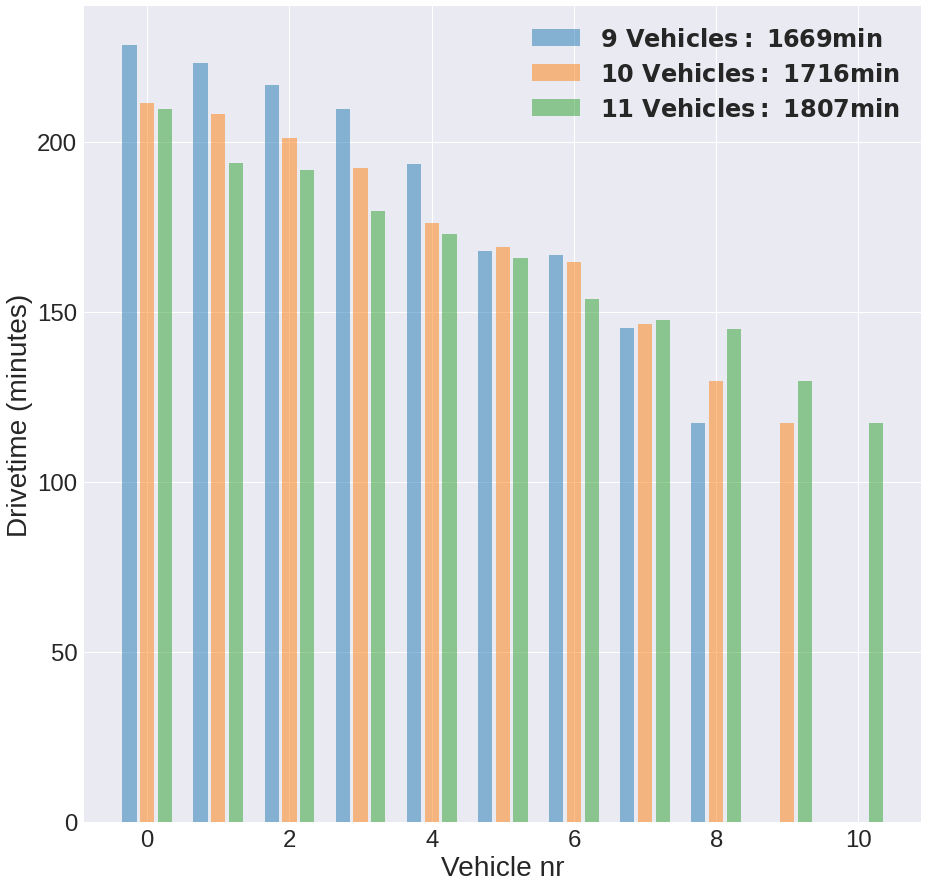

In [135]:

data_name = "UK50_1"

IBEA_pickup_and_drop = combine_datasets("IBEA_pick_and_drop", "parameter_data/pick_and_drop_results/", data_name)
plot_vehicle_drivetimes(IBEA_pickup_and_drop,data_name)

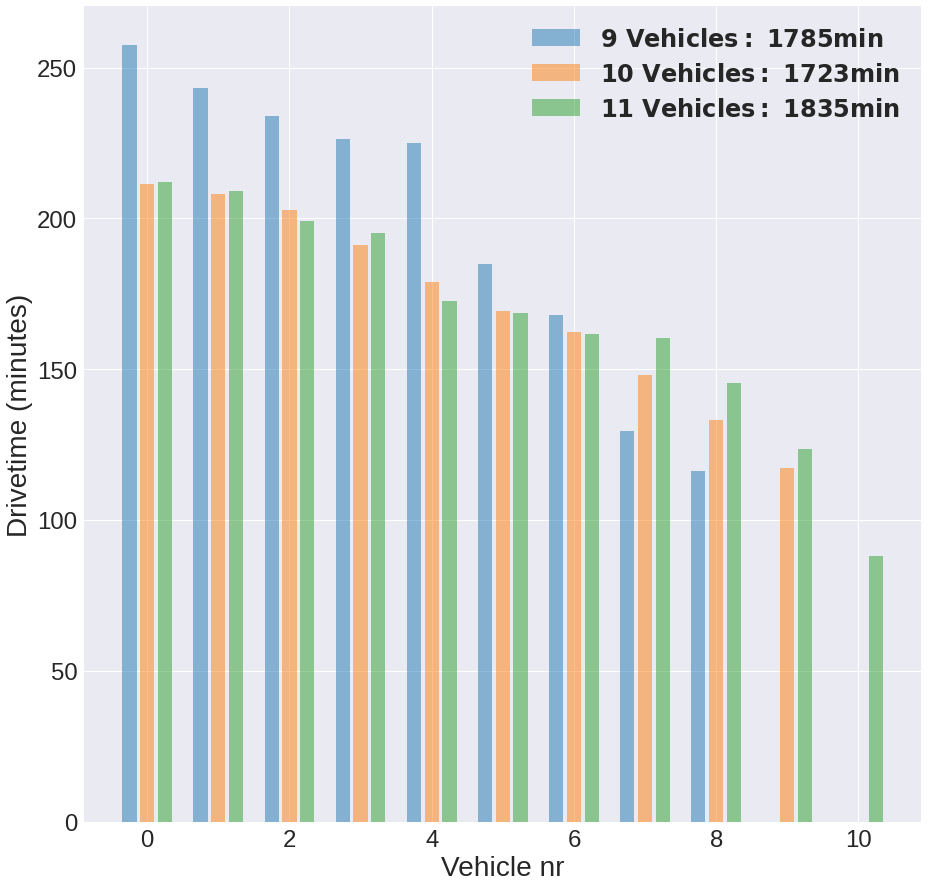

In [136]:
plot_vehicle_drivetimes(IBEA_data_evaluation_limited,"UK50_1")

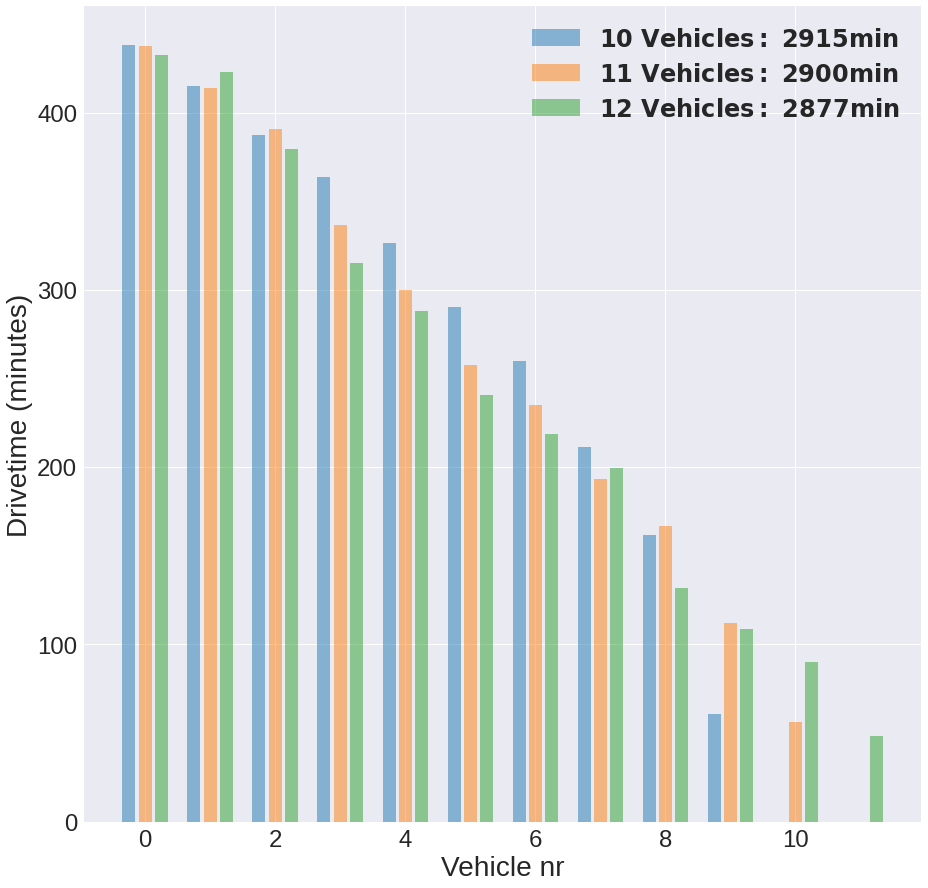

In [124]:

data_name = "UK75_1"

IBEA_pickup_and_drop = combine_datasets("IBEA_pick_and_drop", "parameter_data/pick_and_drop_results/", data_name)
plot_vehicle_drivetimes(IBEA_pickup_and_drop,data_name)

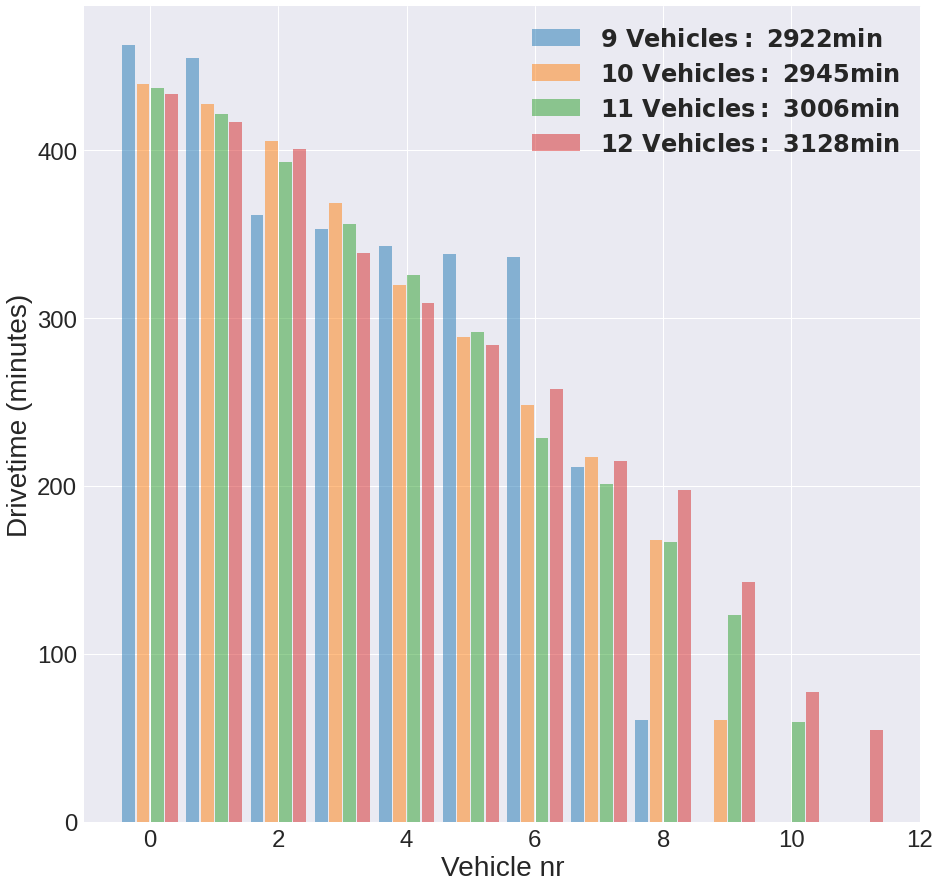

In [125]:
plot_vehicle_drivetimes(IBEA_data_evaluation_limited,"UK75_1")

In [439]:
dataset_names = ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]

In [450]:
gini_index_mean = [np.mean(get_gini_coefficients(IBEA_data_evaluation_limited,dataset)) for dataset in dataset_names]
plt.bar(x=range(0,len(gini_index_mean)),height=gini_index_mean)
gini_index_mean   

[0.1074732779623675,
 0.3005971032809036,
 0.1998126029064819,
 0.10347523528732641,
 0.1711415503306531,
 0.15410559561063958,
 0.2445697744534986,
 0.22439309569277485,
 0.19489187866954227]

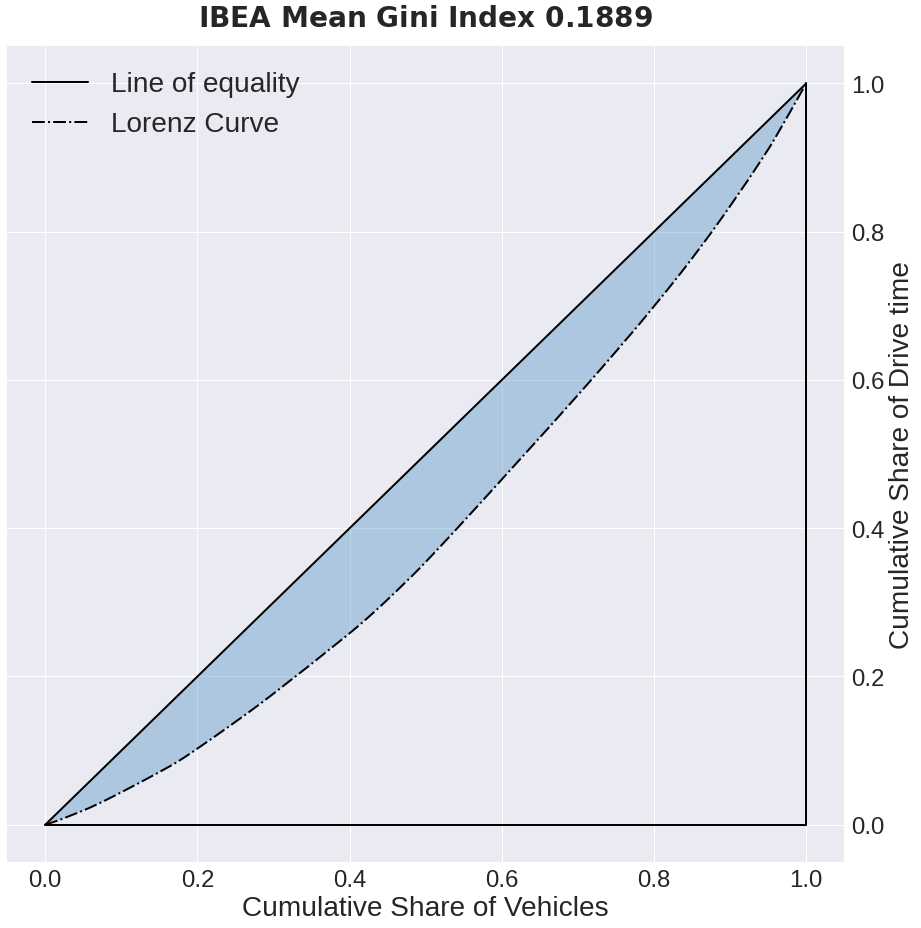

In [434]:
plot_gini_distribution(IBEA_data_evaluation_limited,"IBEA")    

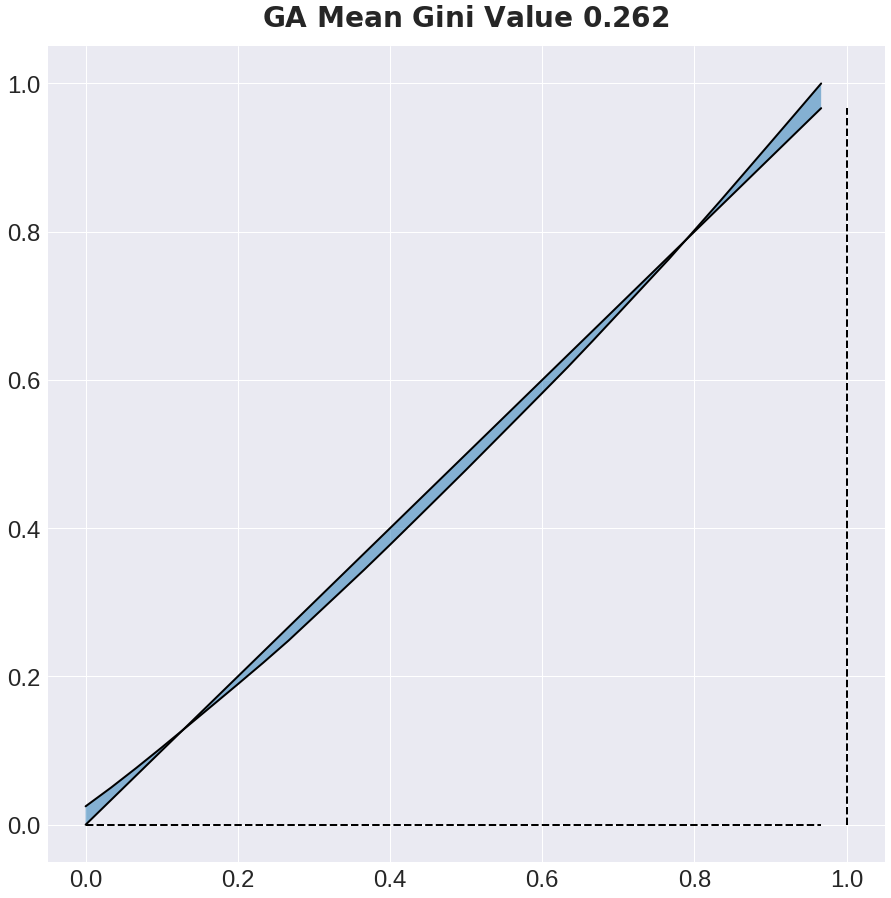

In [273]:
plot_gini_distribution(GA_data_evaluation_limited,"GA","UK75_1")   

In [179]:
def gini_coefficient(x):
    """Compute Gini coefficient of array of values
    https://stackoverflow.com/a/61154922/12463908"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))
IBEA_pickup_and_drop = combine_datasets("IBEA_pick_and_drop", "parameter_data/pick_and_drop_results/")
test = [np.array(x) for x in IBEA_pickup_and_drop.vehicle_route_time.to_numpy()]
coefficients = []
for x in test:
    coefficients.append(gini_coefficient(x))

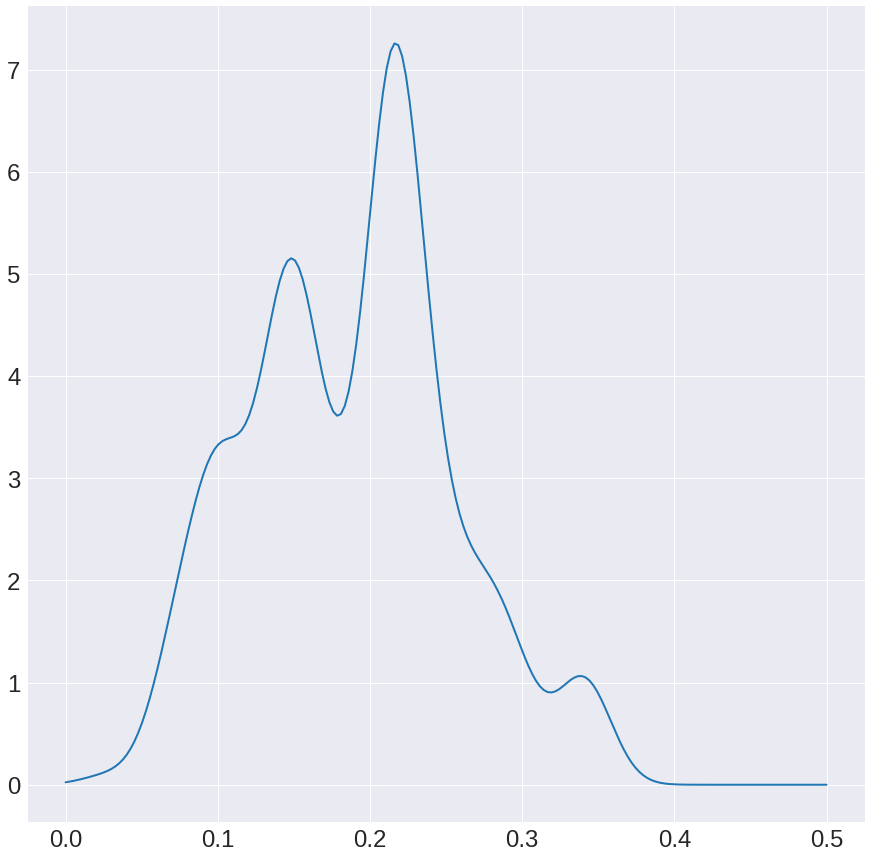

In [174]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
data = coefficients
density = gaussian_kde(data)
xs = np.linspace(0,0.5,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs),linestyle="-")
plt.show()

50


<ipython-input-167-219c7cdd7e91>:24: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



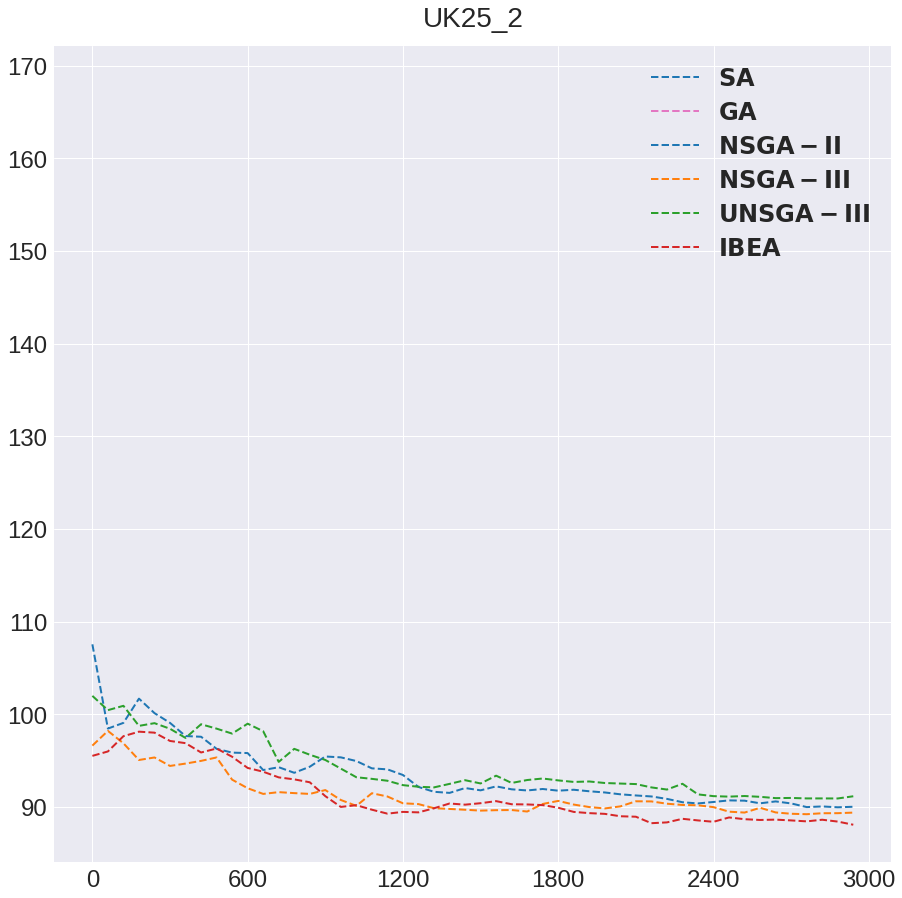

50


<ipython-input-167-219c7cdd7e91>:24: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



50


<ipython-input-167-219c7cdd7e91>:24: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



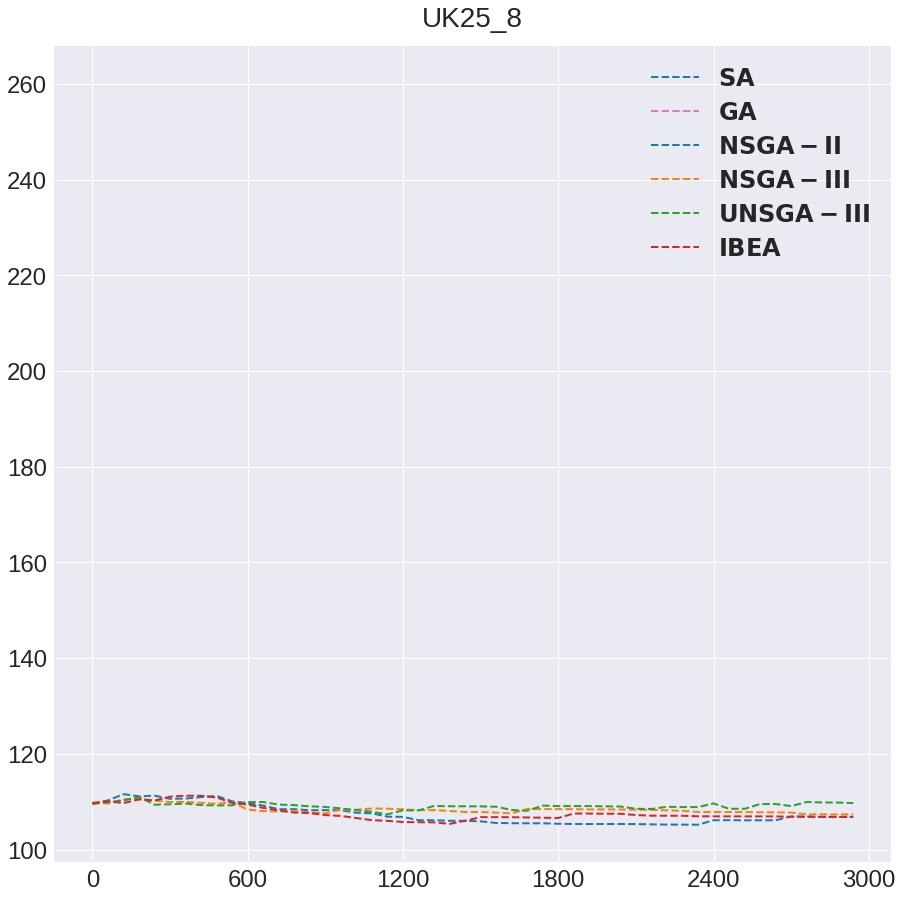

<ipython-input-167-219c7cdd7e91>:24: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



83


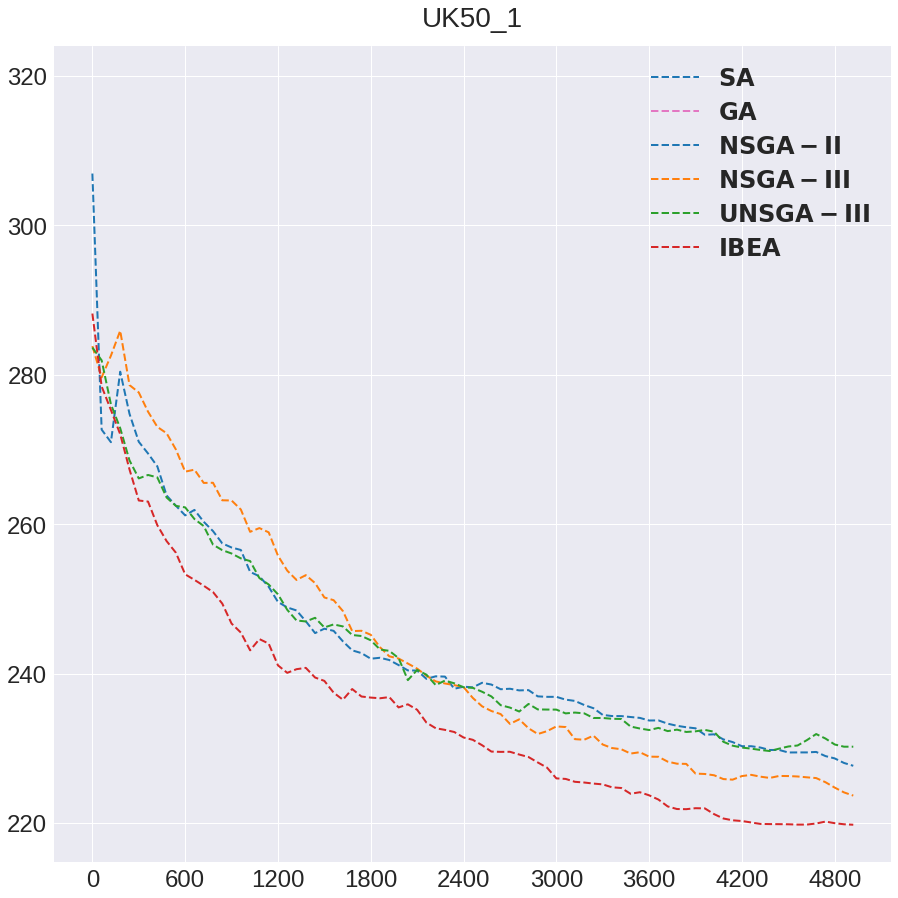

<ipython-input-167-219c7cdd7e91>:24: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



83


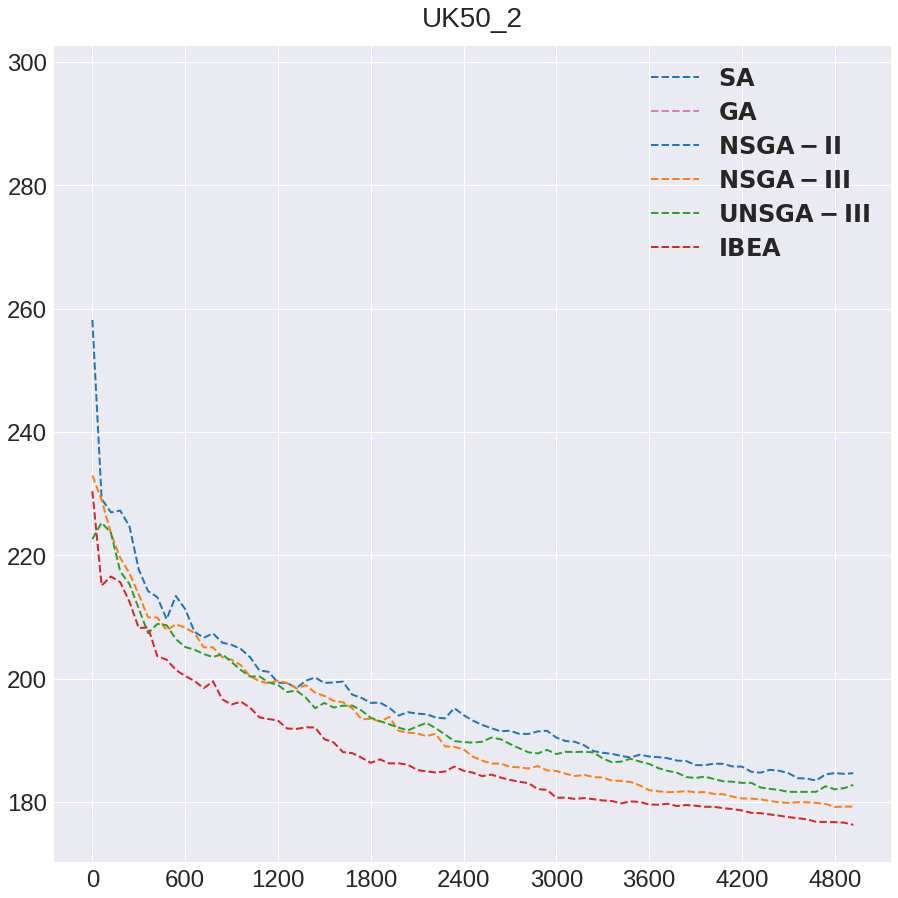

83


<ipython-input-167-219c7cdd7e91>:24: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



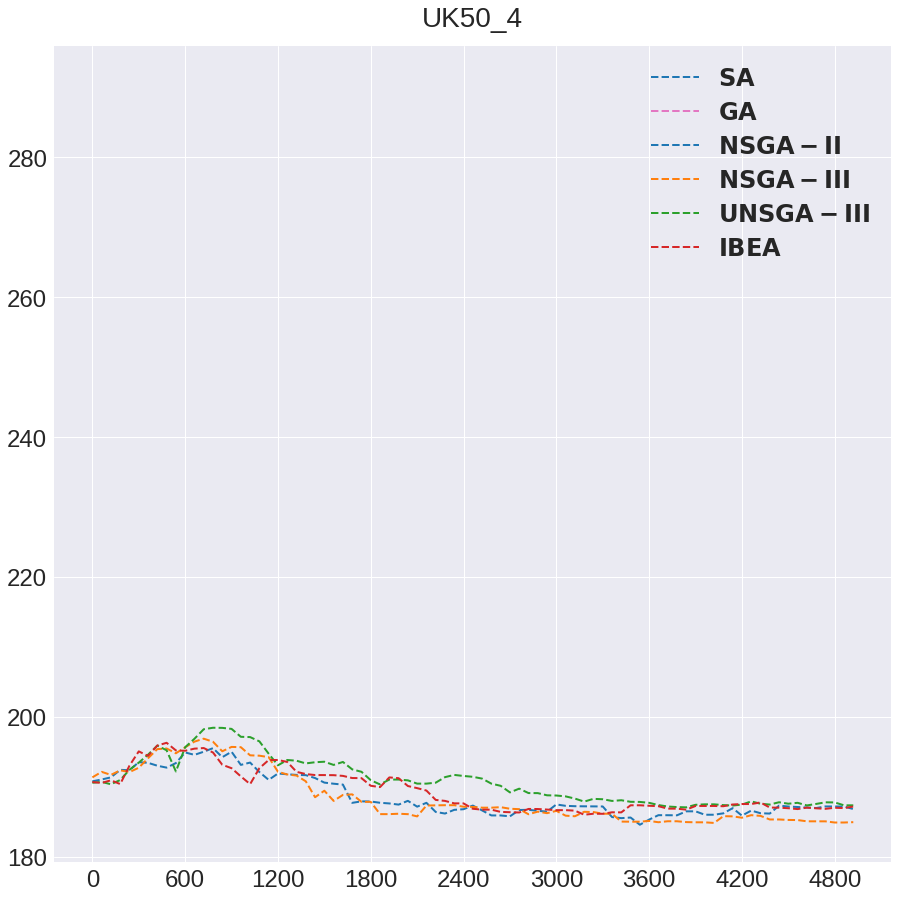

<ipython-input-167-219c7cdd7e91>:24: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



166


<ipython-input-167-219c7cdd7e91>:24: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



166


<ipython-input-167-219c7cdd7e91>:24: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



166


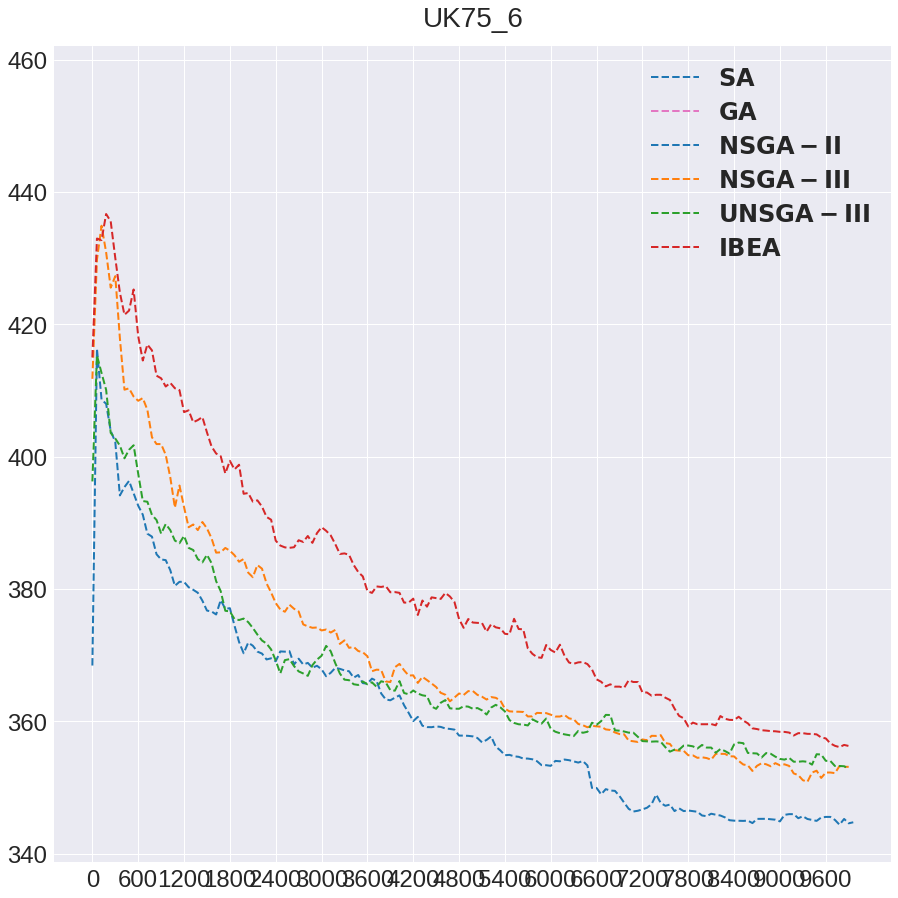

In [167]:
for dataset in ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]:
    x_max = {"UK25":3600,"UK50":5000,"UK75":10000}
    x_max_init = {"UK25":50,"UK50":80,"UK75":175}
    
    SA_data_evaluation_limited_unique = combine_datasets("SA", "parameter_data/reruns/", dataset)
    GA_data_evaluation_limited_unique = combine_datasets("GA", "parameter_data/reruns/", dataset)
 
    NSGA2_data_evaluation_limited_unique = combine_datasets("NSGA2", "parameter_data/reruns_L1/", dataset)
    NSGA3_data_evaluation_limited_unique = combine_datasets("NSGA3", "parameter_data/reruns_L1/", dataset)
    UNSGA3_data_evaluation_limited_unique = combine_datasets("UNSGA3", "parameter_data/reruns_L1/", dataset)
    IBEA_data_evaluation_limited_unique = combine_datasets("IBEA", "parameter_data/reruns_L1/", dataset)
    
    algorithms = [SA_data_evaluation_limited_unique, GA_data_evaluation_limited_unique, NSGA2_data_evaluation_limited_unique, NSGA3_data_evaluation_limited_unique, UNSGA3_data_evaluation_limited_unique, IBEA_data_evaluation_limited_unique]
    add_minmax_fuel_drivetime_columns(algorithms)
    
    
    sa_curve = np.mean([x[1].distance_to_origin for x in SA_data_evaluation_limited_unique.iterrows()],axis=0)
    ga_curve = np.mean([x[1].distance_to_origin for x in GA_data_evaluation_limited_unique.iterrows()],axis=0)
    nsga2_curve = np.mean([x[1].fuel_consumption for x in NSGA2_data_evaluation_limited_unique.iterrows()],axis=0)
    nsga3_curve = np.mean([x[1].fuel_consumption for x in NSGA3_data_evaluation_limited_unique.iterrows()],axis=0)
    unsga3_curve = np.mean([x[1].fuel_consumption for x in UNSGA3_data_evaluation_limited_unique.iterrows()],axis=0)
    ibea_curve = np.mean([x[1].fuel_consumption for x in IBEA_data_evaluation_limited_unique.iterrows()],axis=0)
    
    curves=np.array([sa_curve,ga_curve,nsga2_curve,nsga3_curve,unsga3_curve,ibea_curve])
    labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
    plot_conv_curves(curves,labels,show_domination_and_percentage_interval=False)
    plt.title(dataset)
    
    plt.xticks(ticks=range(0,len(nsga3_curve)+1,10),labels=range(0,x_max[dataset[:4]],600))
    print(len(nsga3_curve))
    
    plt.show()